In [1]:
if (!requireNamespace('BiocManager', quietly = TRUE))
install.packages('BiocManager')

# BiocManager::install('EnhancedVolcano')

BiocManager::install('airway')


'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.10 (BiocManager 1.30.15), R 3.6.3 (2020-02-29)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'airway'”
Old packages: 'BiocManager', 'broom', 'cachem', 'caret', 'colorspace',
  'corrplot', 'cpp11', 'curl', 'data.table', 'devtools', 'dplyr', 'e1071',
  'fansi', 'fastcluster', 'fields', 'formatR', 'furrr', 'gert', 'ggplot2',
  'ggsignif', 'glmnet', 'gtools', 'hms', 'htmlTable', 'lme4', 'Matrix',
  'matrixStats', 'mgcv', 'mime', 'mvtnorm', 'network', 'openxlsx',
  'parallelly', 'parsnip', 'pillar', 'proxy', 'psych', 'quantreg', 'rbibutils',
  'RcppArmadillo', 'Rdpack', 'remotes', 'rio', 'rmarkdown', 'rversions',
  'sandwich', 'shape', 'spam', 'stringi', 'testthat', 'tibble', 'tinytex',
  'xfun', 'zip'



In [12]:
.mySampleScoreArrangerFn=function(inputPath){
  #This function reads in the sample scores (between 0 and 1)
  # inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/classification_perm/"
  # inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_classificationSet_main/"

  resCombined=list()
  # tmpFiles=list.files(inputPath)
  tmpFiles = read.table(paste0(inputPath,"dataList.txt"))
  path=unlist(strsplit(inputPath,"/"))
  path=path[-length(path)]
  path=paste(path,collapse = "/")
  path=paste0(path,"/")
  # tmpFiles = as.vector(tmpFiles)
  if((length(tmpFiles))!=25){
    print(paste("caution: number of files is",(length(tmpFiles$V1))))
  }
  
  for(i in 1:(length(tmpFiles$V1))){
    # 
    # strsplit(status,"_")

    load(paste0(path,tmpFiles$V1[i],"results.rda"))
    
    tmp=result$ROCdf
    
    resdf=list()
    for(j in 1:length(tmp)){
      #print(j)
      tmpdf=tmp[[j]][[1]]
      tmpdf$status=tmp[[j]][[2]]
      colnames(tmpdf)=c("sampleName","real","estimated","status")
      resdf=c(resdf,list(tmpdf))
    }
    resdf=do.call("rbind",resdf)
    resdf=resdf[!duplicated(paste0(resdf$sampleName,"_",resdf$status)),]
    resCombined=c(resCombined,list(resdf))
  }
  
  return(resCombined)
}
.myClassificationEvaluationFn=function(testLabelsHat,testLabels){
  require(PRROC,quietly=T)
  require(pROC,quietly=T)
  
  finalResPR=pr.curve(scores.class0=testLabelsHat,weights.class0=testLabels)$auc.integral
  finalResROC=as.numeric(roc(response=testLabels,predictor=as.vector(testLabelsHat))$auc)
  
  return(list(ROC=finalResROC,PR=finalResPR,ROCdata=roc(response=testLabels,predictor=as.vector(testLabelsHat)),PRdata=pr.curve(scores.class0=testLabelsHat,weights.class0=testLabels)))
}
.myResultOrganizerFn=function(inputPath,countThr=NULL,replaceZero=F){
  #results with number of folds less than the countThr are set to zero
  #zeros can be replaced with 0.5 (ROC and PR)
  load(inputPath)
  inputData=ROCres
  
  if(is.null(countThr)){
    countThr=max(inputData[[2]])
  }
  
  inputData[[1]][inputData[[2]]<countThr]=0
  if(replaceZero){
    inputData[[1]][inputData[[1]]==0]=0.5
  }
  res=inputData[[1]]
  
  thr=0
  if(replaceZero){
    thr=0.5
  }
  x=apply(res,1,function(x) sum(x==thr))
  res=res[which(x<(ncol(inputData[[1]])-1)),]
  return(res)
}

In [3]:
library(ggplot2)
library(reshape2)
library(limma)
library(gplots)


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




test

In [4]:
# inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/"
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/"

inputROCthr=0.7
inputROCPower=2
colorset=c("black","red",'purple')
wCompleteDS=F
# load(paste0(inputPath,"ResultsArranged.rda"))
weightsROC=.myResultOrganizerFn(paste0(inputPath,"ResultsArranged.rda"),replaceZero = T)
load(paste0(inputPath,"ResultsArranged.rda"))
PRs=PRres[[1]]
PRs=PRs[row.names(PRs) %in% row.names(weightsROC),]
PRs_counts=PRres[[2]]
PRs_counts=PRs_counts[row.names(PRs_counts) %in% row.names(weightsROC),]
PRs=PRs[,-which(colnames(PRs)=="sqda")]
PRs_counts=PRs_counts[,-which(colnames(PRs_counts)=="sqda")]

ROCs=ROCres[[1]]
ROCs=ROCs[row.names(ROCs) %in% row.names(weightsROC),]
ROCs_counts=ROCres[[2]]
ROCs_counts=ROCs_counts[row.names(ROCs_counts) %in% row.names(weightsROC),]
ROCs=ROCs[,-which(colnames(ROCs)=="sqda")]
ROCs_counts=ROCs_counts[,-which(colnames(ROCs_counts)=="sqda")]

countThr=max(ROCs_counts)
slInd=as.data.frame(which(ROCs_counts<countThr,arr.ind = T))
slInd=unique(slInd$row)
weightsROC=weightsROC[-which(row.names(weightsROC) %in% row.names(ROCs_counts)[slInd]),]
ROCs=ROCs[-which(row.names(ROCs) %in% row.names(ROCs_counts)[slInd]),]
PRs=PRs[-which(row.names(PRs) %in% row.names(ROCs_counts)[slInd]),]
PRs_counts=PRs_counts[-which(row.names(PRs_counts) %in% row.names(ROCs_counts)[slInd]),]
ROCs_counts=ROCs_counts[-which(row.names(ROCs_counts) %in% row.names(ROCs_counts)[slInd]),]
if(sum(colnames(weightsROC)=="sqda")>0){
weightsROC=weightsROC[,-which(colnames(weightsROC)=="sqda")]
}

print("Number of models:")
print(dim(weightsROC))

print("max scores per classifier:")
print(apply(weightsROC,2,max))
pdf(file=paste0(inputPath,"boxplot.pdf"))
boxplot(weightsROC,legend = F)
dev.off()


[1] "Number of models:"
[1] 1410   12
[1] "max scores per classifier:"
             reg           logReg              lda              qda 
       0.8908918        0.9022770        0.8946869        0.8927894 
        ridgeReg         lassoReg      ridgeLogReg      lassoLogReg 
       0.8880455        0.8946869        0.8937381        0.8937381 
elasticNetLogReg     randomForest         boosting          bagging 
       0.8937381        0.8913662        0.8913662        0.8951613 


pdf 
  2

Saving 7 x 7 in image



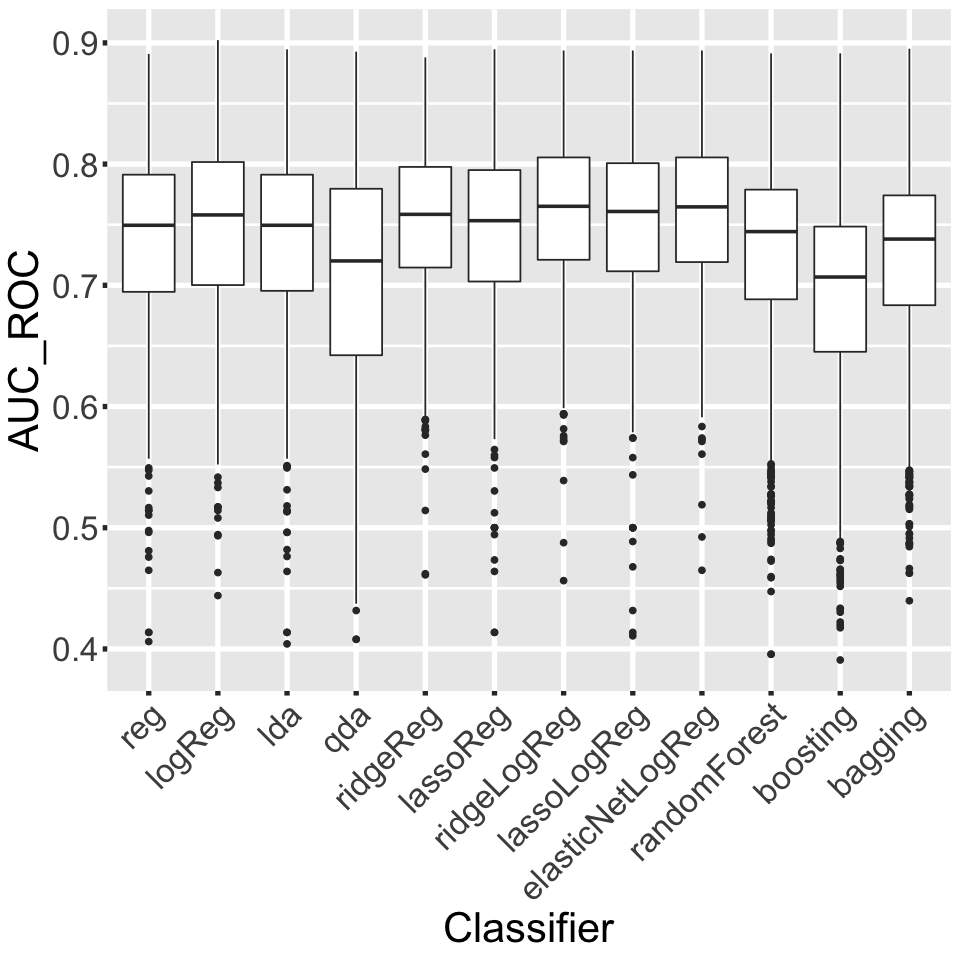

In [5]:
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"
temp_data=melt(weightsROC)
colnames(temp_data) = c('var1', 'Classifier', 'AUC_ROC')
# pdf(file=paste0(inputPath,"test_boxplot.pdf"), width = 4.5, height = 5)
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(temp_data, aes(x=Classifier, y=AUC_ROC)) +
  geom_boxplot(outlier.size=1.5) +
  theme(axis.text.x = element_text(angle = 45,hjust=1),text = element_text(size = 25), element_line(size = 1.5))
ggsave(paste0(inputPath,"myplot.png"))


# main

In [6]:
# inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/"
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_classificationSet_main/"

inputROCthr=0.7
inputROCPower=2
colorset=c("black","red")
wCompleteDS=F
# load(paste0(inputPath,"ResultsArranged.rda"))
weightsROC=.myResultOrganizerFn(paste0(inputPath,"ResultsArranged.rda"),replaceZero = T)
load(paste0(inputPath,"ResultsArranged.rda"))
PRs=PRres[[1]]
PRs=PRs[row.names(PRs) %in% row.names(weightsROC),]
PRs_counts=PRres[[2]]
PRs_counts=PRs_counts[row.names(PRs_counts) %in% row.names(weightsROC),]
PRs=PRs[,-which(colnames(PRs)=="sqda")]
PRs_counts=PRs_counts[,-which(colnames(PRs_counts)=="sqda")]

ROCs=ROCres[[1]]
ROCs=ROCs[row.names(ROCs) %in% row.names(weightsROC),]
ROCs_counts=ROCres[[2]]
ROCs_counts=ROCs_counts[row.names(ROCs_counts) %in% row.names(weightsROC),]
ROCs=ROCs[,-which(colnames(ROCs)=="sqda")]
ROCs_counts=ROCs_counts[,-which(colnames(ROCs_counts)=="sqda")]

countThr=max(ROCs_counts)
slInd=as.data.frame(which(ROCs_counts<countThr,arr.ind = T))
slInd=unique(slInd$row)
weightsROC=weightsROC[-which(row.names(weightsROC) %in% row.names(ROCs_counts)[slInd]),]
ROCs=ROCs[-which(row.names(ROCs) %in% row.names(ROCs_counts)[slInd]),]
PRs=PRs[-which(row.names(PRs) %in% row.names(ROCs_counts)[slInd]),]
PRs_counts=PRs_counts[-which(row.names(PRs_counts) %in% row.names(ROCs_counts)[slInd]),]
ROCs_counts=ROCs_counts[-which(row.names(ROCs_counts) %in% row.names(ROCs_counts)[slInd]),]
if(sum(colnames(weightsROC)=="sqda")>0){
weightsROC=weightsROC[,-which(colnames(weightsROC)=="sqda")]
}

print("Number of models:")
print(dim(weightsROC))

print("max scores per classifier:")
print(apply(weightsROC,2,max))
pdf(file=paste0(inputPath,"boxplot.pdf"))
boxplot(weightsROC,legend = F)
dev.off()


[1] "Number of models:"
[1] 1320   12
[1] "max scores per classifier:"
             reg           logReg              lda              qda 
       0.8731897        0.8551711        0.8741877        0.8399541 
        ridgeReg         lassoReg      ridgeLogReg      lassoLogReg 
       0.8573805        0.8692222        0.8551384        0.8560352 
elasticNetLogReg     randomForest         boosting          bagging 
       0.8557890        0.8332094        0.8308230        0.8382445 


pdf 
  2

In [7]:
temp_data=melt(weightsROC)
colnames(temp_data) = c('var1', 'Classifier', 'AUC_ROC')
pdf(file=paste0(inputPath,"boxplot.pdf"), width = 4.5, height = 5)
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(temp_data, aes(x=Classifier, y=AUC_ROC)) +
  geom_boxplot(outlier.size=1.5) +
  theme(axis.text.x = element_text(angle = 45,hjust=1),text = element_text(size = 25), element_line(size = 1.5))
dev.off()


pdf 
  2

Saving 7 x 7 in image



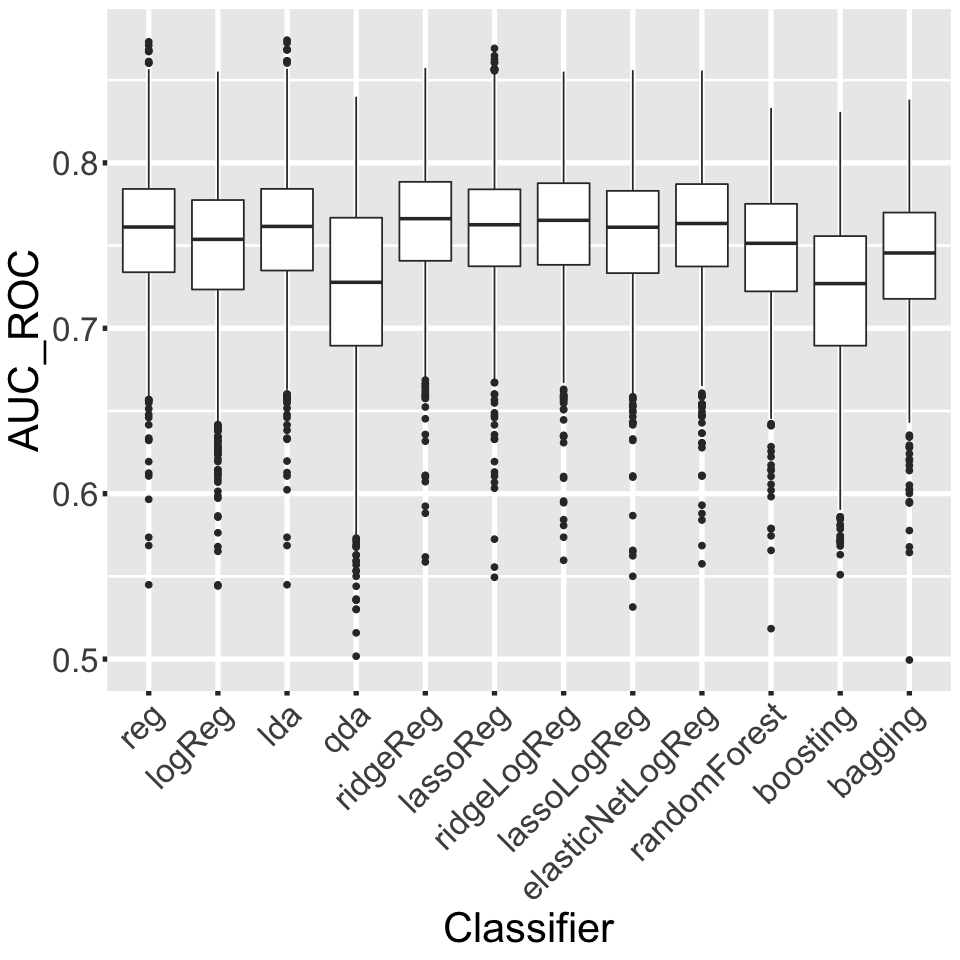

In [8]:
# png(file=paste0(inputPath,"boxplot.png"), width = 4, height = 4.5)
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(temp_data, aes(x=Classifier, y=AUC_ROC)) +
  geom_boxplot(outlier.size=1.5) +
  theme(axis.text.x = element_text(angle = 45,hjust=1),text = element_text(size = 25), element_line(size = 1.5))
# dev.off()
ggsave(paste0(inputPath,"boxplot.png"))

In [9]:
data=.mySampleScoreArrangerFn("/Volumes/Work/Vahid_work/classification_newcode_data/final_classificationSet_main/")

# dim(data) in train+ main "4209360 4
# dim(data) #in main 3748014
data=do.call("rbind",data)
status=gsub("^independent","^independent_1",data$status)
#removing the fold information from feature selection routes to allow the integration of results across folds
status=strsplit(status,"_")
status=unlist(lapply(status, function(x)paste(x[3:length(x)],collapse = "_")))
data$statusUpdated=status #statusUpdated: feature selection route without info on the fold
rm(status)

[1] "caution: number of files is 25"


In [10]:
dim(data)

[1] 3748014       5

In [11]:
data_1=.mySampleScoreArrangerFn("/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/")
# dim(data) in train+ main "4209360 4
# dim(data) in main 3748014
data_1=do.call("rbind",data_1)
status=gsub("^independent","^independent_1",data_1$status)
#removing the fold information from feature selection routes to allow the integration of results across folds
status=strsplit(status,"_")
status=unlist(lapply(status, function(x)paste(x[3:length(x)],collapse = "_")))
data_1$statusUpdated=status #statusUpdated: feature selection route without info on the fold
rm(status)

[1] "caution: number of files is 5"


In [12]:
data=rbind(data, data_1)

In [13]:
dim(data_1)

[1] 1140035       5

In [14]:
#weighting the scores based on the model's ROC

x=as.data.frame(weightsROC)
x$id=row.names(x)
x=reshape2::melt(x,by="id")

x=as.data.frame(weightsROC)
x$id=row.names(x)
x=reshape2::melt(x,by="id")

x2=strsplit(x$id,"_")
x2=unlist(lapply(x2,function(x)paste(x[2:length(x)],collapse = "_")))
x2=paste0(x2,"_",as.character(x$variable))
x2=gsub("independent","real",x2)
# x2=gsub("perm1","real",x2)
# x2=gsub("perm2","real",x2)
# x2=gsub("perm3","real",x2)
# x2=gsub("perm4","real",x2)
# x2=gsub("perm5","real",x2)
x$status=x2
                 
data=data[data$statusUpdated %in% x$status,]
x=x[x$status %in% data$statusUpdated,]


Using id as id variables

Using id as id variables



In [15]:
dim(data) # main 2772000 258240 3794580


[1] 3794580       5

In [16]:
x=x[,c("status","value")]
colnames(x)[2]="weightROC"
data=merge(data,x,by.x='statusUpdated',by.y="status")
rm(x)


In [17]:
# check for data abnormal, tmp is null is safe
tmp=as.data.frame(table(data$status[data$estimated>1]))
tmp
tmp=strsplit(as.character(tmp$Var1),"_")
tmp=unlist(lapply(tmp,function(x) x[length(x)]))

Freq
<int>


In [18]:
data=data[which(data$estimated>=0 & data$estimated<=1),]
data$id=paste0(data$statusUpdated,"_",data$sampleName)
data=list(data=data)
data$average=aggregate(estimated~id,data=data$data,FUN=mean)
                 

In [19]:
# save(data, file="/Volumes/Work/Vahid_work/classification_newcode_data/tempero.rda")

In [29]:
load("/Volumes/Work/Vahid_work/classification_newcode_data/tempero.rda")

data3=data$data[,c("id","sampleName","real","statusUpdated","weightROC")]
data3=data3[!duplicated(data3$id),]
data3=merge(data$average,data3,by="id")
data$average=data3
rm(data3)
                      
data$average$modWeightROC=data$average$weightROC-0.7  
data$average$modWeightROC[which(data$average$modWeightROC<0)]=0


In [30]:
length(data$average$weightROC)

[1] 3794580

# Using the model that >0.8 in the main

In [31]:
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_all.rda")

row.names(dataTest$data$weightsROC)=gsub("independent","real",row.names(dataTest$data$weightsROC))

x=dataTest$data$weightsROC
x=x[row.names(x) %in% row.names(dataMain$data$weightsROC),]

x2=as.data.frame(which(dataMain$data$weightsROC>0.8,arr.ind = T))

counter=0
slFeatures= c()
sl_models = c()
sl_model_main = c()
x2=x2[row.names(dataMain$data$weightsROC)[x2$row] %in% row.names(dataTest$data$weightsROC),]
for(i in 1:nrow(x2)){
  if(x[row.names(dataMain$data$weightsROC)[x2$row[i]],colnames(dataMain$data$weightsROC)[x2$col[i]]]>=0.75){
    counter=counter+1
    slFeatures=c(slFeatures,row.names(dataMain$data$weightsROC)[x2$row[i]])
    sl_models=c(sl_models, paste(row.names(dataMain$data$weightsROC)[x2$row[i]],colnames(dataMain$data$weightsROC)[x2$col[i]], sep="_"))
  }
    sl_model_main=c(sl_model_main, paste(row.names(dataMain$data$weightsROC)[x2$row[i]],colnames(dataMain$data$weightsROC)[x2$col[i]], sep="_"))

}
# sl_models
name_refined = c()
for(i in 1:length(sl_models)){
  temp_name = unlist(strsplit(sl_models[i],"_"))
  temp_name = temp_name[-1]
  temp_name = paste(temp_name,collapse = "_")
  name_refined = c(name_refined, temp_name)
}
name_main_refined = c()

for(i in 1:length(sl_model_main)){
  temp_name = unlist(strsplit(sl_model_main[i],"_"))
  temp_name = temp_name[-1]
  temp_name = paste(temp_name,collapse = "_")
  name_main_refined = c(name_main_refined, temp_name)
}
length(name_refined)
length(name_main_refined)

[1] 1076

[1] 1822

In [32]:
make_composite = TRUE        
if(make_composite){
print(paste0(sum(data$average$statusUpdated %in% name_refined), " subjects used to make composite model"))
    # in train+ main "258240 subjects used to make composite model"
data$average$modWeightROC[which(!data$average$statusUpdated %in% name_refined)] = 0.0
}
data$average$weightedEstimate=data$average$estimated*(data$average$modWeightROC)^1

[1] "258240 subjects used to make composite model"


[1] 258240

[1] 258240

[1] 3794580

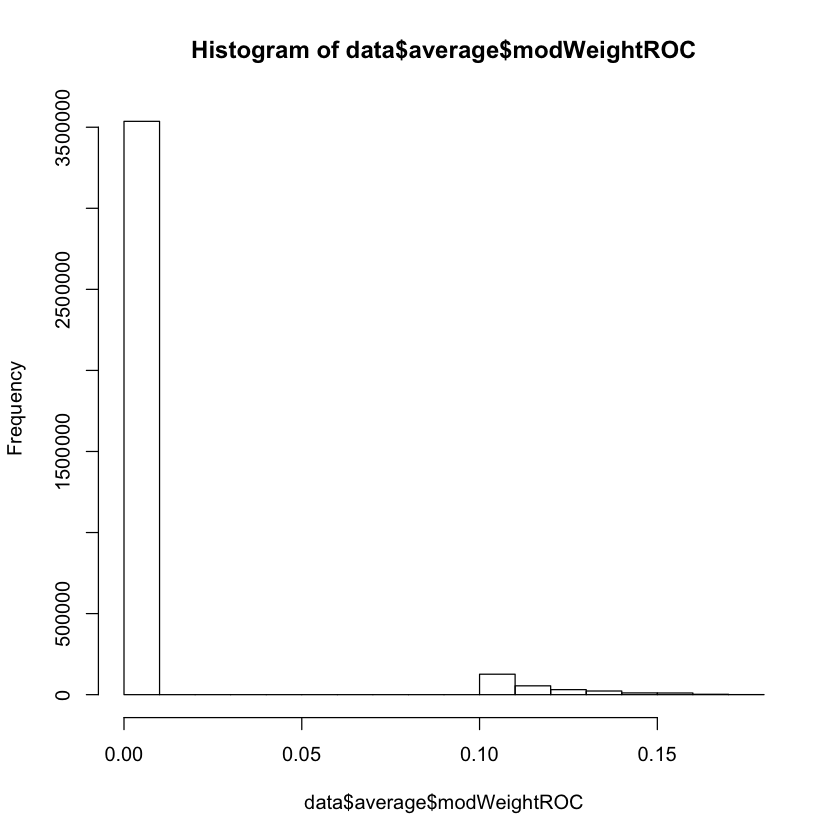

In [33]:
sum(data$average$statusUpdated %in% name_refined)
# sum(data$average$statusUpdated %in% name_main_refined)
sum(data$average$modWeightROC>0)
length(data$average$modWeightROC)
hist(data$average$modWeightROC)

In [34]:
data3=data$average
data3$dx=paste0(data3$statusUpdated,"_dx",data3$real)
tmp=data3[,c("dx","real")]
tmp=tmp[!duplicated(tmp$dx),]
data3med=aggregate(weightedEstimate~dx,data=data3,median)
data$overallSubjectMean=merge(data3med,tmp,by="dx")
rm(tmp,data3med,data3)
status=data$overallSubjectMean$dx
status=strsplit(status,"_")
status=unlist(lapply(status,function(x) paste(x[1:(length(x)-1)],collapse = "_")))
data$overallSubjectMean$status=status
rm(status)
data$average$group='test'
data$average$group[which(data$average$sampleName %in% dataMain$data$concensus$sampleName)]='main'


# output for main

In [35]:
# the_mean = mean(data$concensus$weightedEstimate[data$concensus$real==1])
# the_mean

In [36]:
# data$concensus$real
library(ggplot2)
library(reshape2)
library(limma)
library(gplots)

In [37]:
tmp=dcast(data = data$average[which(data$average$group=='main'),],formula = statusUpdated~sampleName,fun.aggregate = sum,value.var = "weightedEstimate")

tmp2=data$average[,c("sampleName","real")]
tmp2=tmp2[!duplicated(tmp2$sampleName),]
             
data$concensus=apply(tmp[,-1],2,sum)
dim(data$concensus)
data$concensus=data.frame(sampleName=names(data$concensus),weightedEstimate=data$concensus,stringsAsFactors = F)
data$concensus=merge(data$concensus,tmp2,by="sampleName")

data$concensus$weightedEstimate=data$concensus$weightedEstimate - min(data$concensus$weightedEstimate)
data$concensus$weightedEstimate=data$concensus$weightedEstimate/max(data$concensus$weightedEstimate)
the_mean = mean(data$concensus$weightedEstimate[data$concensus$real==1])

length(data$concensus$real)
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.9)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.8)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.75)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.7)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.65)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.6)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.55)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.5)))
print(.myClassificationEvaluationFn(data$concensus$weightedEstimate,data$concensus$real))

# data$weightsROC=weightsROC

df=data.frame(sampleName=colnames(tmp),isSel=1,stringsAsFactors = F)
df=df[!duplicated(df$sampleName),]
df=merge(df,data.frame(sampleName=data$average$sampleName,real=data$average$real,weightedEstimate=data$average$weightedEstimate, stringsAsFactors = F),by="sampleName")
df=df[!duplicated(df$sampleName),]
df=df[match(colnames(tmp)[-1],df$sampleName),]

the_mean
df$category="other"
df$category[df$real==0]="TD"
df$category[df$real==1&data$concensus$weightedEstimate>=the_mean]="good"
df$category[df$real==1&data$concensus$weightedEstimate<the_mean]="poor"
labelsVector=df$category
labcol=rep("black",length(labelsVector))
colramp = colorRampPalette(c("orange","yellow","black","purple","purple"))(15)
scale="none"
main=""

xx=as.matrix(dist(t(tmp[,-1])))
xxx=cor(xx)
colorset=c("black","red",'orange')

labcol[labelsVector=='TD']=colorset[1]
labcol[labelsVector=='good']=colorset[2]
labcol[labelsVector=='poor']=colorset[3]
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"
pdf(file=paste0(inputPath,"Figure_2_heatmap.a.pdf"))
hm=heatmap.2(as.matrix(dist(t(tmp[,-1]))),
             col=colramp,
             RowSideColors = labcol,
             hclustfun=function(d) stats::hclust(d, method="ward.D2"),
             distfun=function(x) as.dist(1-cor(t(x))), 
             ColSideColors = labcol, 
             margins = c(5,10),
             scale=scale,main=main,trace="none",density.info=c("none")) 
#eval(hm$call)
dev.off()


NULL

[1] 175

   
    FALSE TRUE
  0    81    1
  1    76   17
   
    FALSE TRUE
  0    80    2
  1    60   33
   
    FALSE TRUE
  0    77    5
  1    54   39
   
    FALSE TRUE
  0    75    7
  1    47   46
   
    FALSE TRUE
  0    72   10
  1    42   51
   
    FALSE TRUE
  0    72   10
  1    33   60
   
    FALSE TRUE
  0    70   12
  1    26   67
   
    FALSE TRUE
  0    66   16
  1    22   71


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.844086

$PR
[1] 0.8412215

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 82 controls (testLabels 0) < 93 cases (testLabels 1).
Area under the curve: 0.8441

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8412215 

    Area under curve (Davis & Goadrich):
     0.8409996 

    Curve not computed ( can be done by using curve=TRUE )



[1] 0.7142184

pdf 
  2

# output for test

In [38]:
tmp=dcast(data = data$average[which(data$average$group=='test'),],formula = statusUpdated~sampleName,fun.aggregate = sum,value.var = "weightedEstimate")
#eval(hm$call)
#   dev.off()
tmp2=data$average[,c("sampleName","real")]
tmp2=tmp2[!duplicated(tmp2$sampleName),]
             
data$concensus=apply(tmp[,-1],2,sum)
dim(data$concensus)
data$concensus=data.frame(sampleName=names(data$concensus),weightedEstimate=data$concensus,stringsAsFactors = F)
data$concensus=merge(data$concensus,tmp2,by="sampleName")

data$concensus$weightedEstimate=data$concensus$weightedEstimate - min(data$concensus$weightedEstimate)
data$concensus$weightedEstimate=data$concensus$weightedEstimate/max(data$concensus$weightedEstimate)
length(data$concensus$real)
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.9)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.8)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.75)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.7)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.65)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.6)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.55)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.5)))
print(.myClassificationEvaluationFn(data$concensus$weightedEstimate,data$concensus$real))

# data$weightsROC=weightsROC
             
df=data.frame(sampleName=colnames(tmp),isSel=1,stringsAsFactors = F)
df=df[!duplicated(df$sampleName),]
df=merge(df,data.frame(sampleName=data$average$sampleName,real=data$average$real,weightedEstimate=data$average$weightedEstimate, stringsAsFactors = F),by="sampleName")
df=df[!duplicated(df$sampleName),]
df=df[match(colnames(tmp)[-1],df$sampleName),]

df$category="other"
df$category[df$real==0]="TD"
df$category[df$real==1&data$concensus$weightedEstimate>=the_mean]="good"
df$category[df$real==1&data$concensus$weightedEstimate<the_mean]="poor"
labelsVector=df$category
labcol=rep("black",length(labelsVector))
colramp = colorRampPalette(c("orange","yellow","black","purple","purple"))(15)
scale="none"
main=""

xx=as.matrix(dist(t(tmp[,-1])))
xxx=cor(xx)
colorset=c("black","red",'orange')

labcol[labelsVector=='TD']=colorset[1]
labcol[labelsVector=='good']=colorset[2]
labcol[labelsVector=='poor']=colorset[3]
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"

pdf(file=paste0(inputPath,"Figure_2_heatmap.b.pdf"))
hm=heatmap.2(as.matrix(dist(t(tmp[,-1]))),
             col=colramp,
             RowSideColors = labcol,
             hclustfun=function(d) stats::hclust(d, method="ward.D2"),
             distfun=function(x) as.dist(1-cor(t(x))), 
             ColSideColors = labcol, 
             margins = c(5,10),
             scale=scale,main=main,trace="none",density.info=c("none")) 
dev.off()

NULL

[1] 65

   
    FALSE TRUE
  0    31    0
  1    27    7
   
    FALSE TRUE
  0    31    0
  1    21   13
   
    FALSE TRUE
  0    31    0
  1    18   16
   
    FALSE TRUE
  0    30    1
  1    15   19
   
    FALSE TRUE
  0    30    1
  1    12   22
   
    FALSE TRUE
  0    29    2
  1    10   24
   
    FALSE TRUE
  0    26    5
  1    10   24
   
    FALSE TRUE
  0    25    6
  1     8   26


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8785579

$PR
[1] 0.9115092

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 31 controls (testLabels 0) < 34 cases (testLabels 1).
Area under the curve: 0.8786

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.9115092 

    Area under curve (Davis & Goadrich):
     0.9114988 

    Curve not computed ( can be done by using curve=TRUE )



pdf 
  2


# output for all

In [39]:
head(data$average)

,id,estimated,sampleName,real,statusUpdated,weightROC,modWeightROC,weightedEstimate,group
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,cov_grn1_cppls_bagging_100,0.031,100,1,cov_grn1_cppls_bagging,0.7340489,0,0,test
2,cov_grn1_cppls_bagging_101,0.277,101,1,cov_grn1_cppls_bagging,0.7340489,0,0,main
3,cov_grn1_cppls_bagging_102,0.096,102,0,cov_grn1_cppls_bagging,0.7340489,0,0,test
4,cov_grn1_cppls_bagging_104,0.124,104,0,cov_grn1_cppls_bagging,0.7340489,0,0,test
5,cov_grn1_cppls_bagging_105,0.594,105,0,cov_grn1_cppls_bagging,0.7340489,0,0,test
6,cov_grn1_cppls_bagging_106,0.003,106,1,cov_grn1_cppls_bagging,0.7340489,0,0,main


In [40]:
# normalize the score with main and test

NULL

[1] 240

   
    FALSE TRUE
  0   112    1
  1   104   23
   
    FALSE TRUE
  0   111    2
  1    81   46
   
    FALSE TRUE
  0   106    7
  1    74   53
   
    FALSE TRUE
  0   105    8
  1    63   64
   
    FALSE TRUE
  0   103   10
  1    53   74
   
    FALSE TRUE
  0   101   12
  1    43   84


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8510905

$PR
[1] 0.8544348

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 113 controls (testLabels 0) < 127 cases (testLabels 1).
Area under the curve: 0.8511

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8544348 

    Area under curve (Davis & Goadrich):
     0.8542729 

    Curve not computed ( can be done by using curve=TRUE )



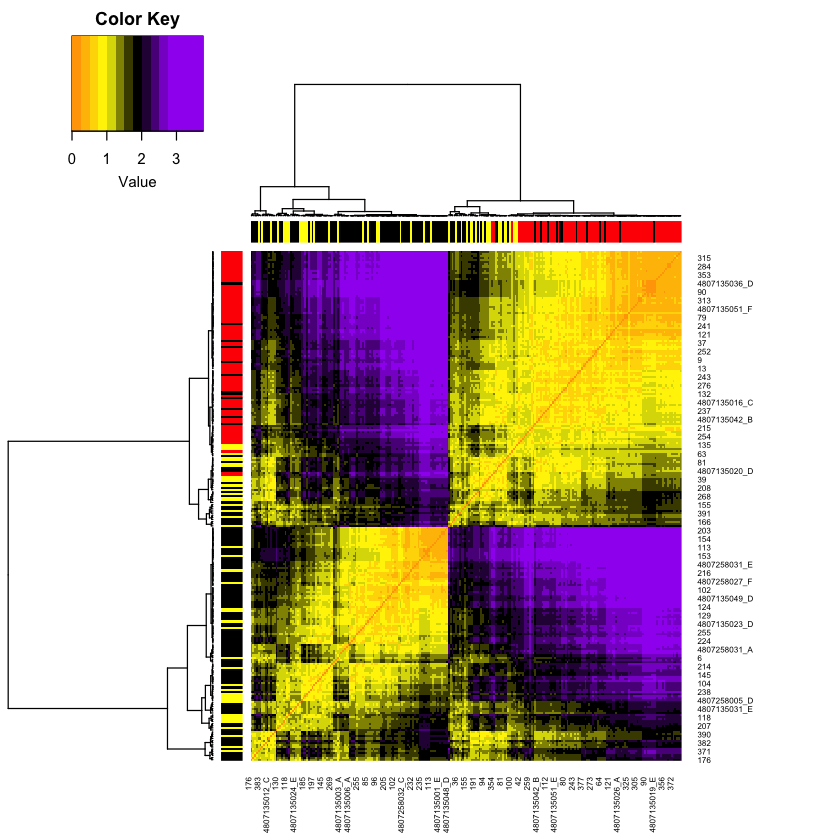

In [42]:
tmp=dcast(data = data$average, formula = statusUpdated~sampleName,fun.aggregate = sum,value.var = "weightedEstimate")

#eval(hm$call)
#   dev.off()
tmp2=data$average[,c("sampleName","real")]
tmp2=tmp2[!duplicated(tmp2$sampleName),]
             
data$concensus=apply(tmp[,-1],2,sum)
dim(data$concensus)
data$concensus=data.frame(sampleName=names(data$concensus),weightedEstimate=data$concensus,stringsAsFactors = F)
data$concensus=merge(data$concensus,tmp2,by="sampleName")

data$concensus$weightedEstimate=data$concensus$weightedEstimate - min(data$concensus$weightedEstimate)
data$concensus$weightedEstimate=data$concensus$weightedEstimate/max(data$concensus$weightedEstimate)
length(data$concensus$real)
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.9)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.8)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.75)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.7)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.65)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.6)))
print(.myClassificationEvaluationFn(data$concensus$weightedEstimate,data$concensus$real))

# data$weightsROC=weightsROC
# data$PR_values=PRs
dataTandM=list(data=data, heatmap=hm)

             
df=data.frame(sampleName=colnames(tmp),isSel=1,stringsAsFactors = F)
df=df[!duplicated(df$sampleName),]
df=merge(df,data.frame(sampleName=data$average$sampleName,real=data$average$real,weightedEstimate=data$average$weightedEstimate, stringsAsFactors = F),by="sampleName")
df=df[!duplicated(df$sampleName),]
df=df[match(colnames(tmp)[-1],df$sampleName),]

df$category="other"
df$category[df$real==0]="TD"
df$category[df$real==1&data$concensus$weightedEstimate>=the_mean]="good"
df$category[df$real==1&data$concensus$weightedEstimate<the_mean]="poor"
labelsVector=df$category
labcol=rep("black",length(labelsVector))
colramp = colorRampPalette(c("orange","yellow","black","purple","purple"))(15)
scale="none"
main=""

xx=as.matrix(dist(t(tmp[,-1])))
xxx=cor(xx)
colorset=c("black","red",'yellow')

labcol[labelsVector=='TD']=colorset[1]
labcol[labelsVector=='good']=colorset[2]
labcol[labelsVector=='poor']=colorset[3]

#   pdf(file=paste0(inputPath,"heatmap.pdf"))
hm=heatmap.2(as.matrix(dist(t(tmp[,-1]))),
             col=colramp,
             RowSideColors = labcol,
             hclustfun=function(d) stats::hclust(d, method="ward.D2"),
             distfun=function(x) as.dist(1-cor(t(x))), 
             ColSideColors = labcol, 
             margins = c(5,10),
             scale=scale,main=main,trace="none",density.info=c("none")) 

In [43]:
library(tidyverse)  # data manipulation
library(cluster)    # clustering algorithms
library(factoextra)
# install.packages("ggpubr")
# install.packages("factoextra")
library(ggpubr)

library(factoextra)

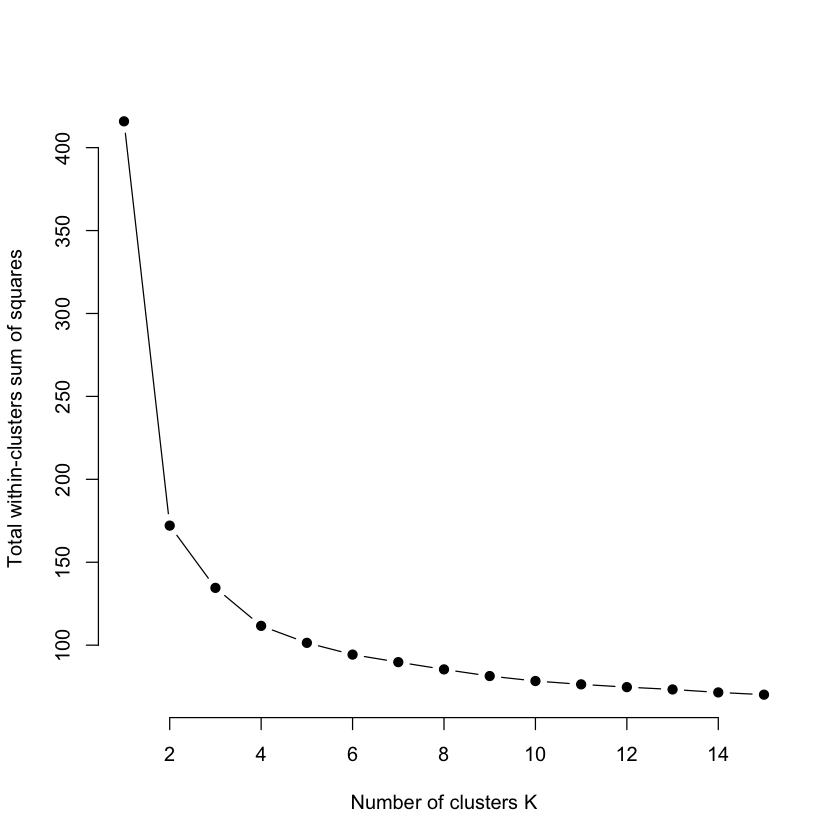

In [44]:
temp_tmp = tmp[which(tmp$statusUpdated %in% name_refined),]
temp_tmp = t(temp_tmp[,c(-1)])
res.km <- kmeans(temp_tmp, 4, nstart = 25)
# K-means clusters showing the group of each individuals
wss <- function(k) {
  kmeans(temp_tmp, k, nstart = 10 )$tot.withinss
}

# Compute and plot wss for k = 1 to k = 15
k.values <- 1:15

# extract wss for 2-15 clusters
wss_values <- map_dbl(k.values, wss)

plot(k.values, wss_values,
       type="b", pch = 19, frame = FALSE, 
       xlab="Number of clusters K",
       ylab="Total within-clusters sum of squares")



In [ ]:
# res.km$real=dMain$real

In [ ]:
# temp_tmp = tmp[which(tmp$statusUpdated %in% name_refined),]
# temp_tmp = t(temp_tmp[,c(-1)])
# res.km <- kmeans(temp_tmp, 5, nstart = 25)
# p1 = fviz_cluster(res.km, data = temp_tmp,
#              geom = "point",
#              ellipse.type = "convex", 
#              ggtheme = theme_bw()
#              )


In [ ]:
# p1$data$real=dMain$real

In [ ]:
# ggplot(p1$data, aes(x=x, y=y)) +
#   geom_point(aes(shape=p1$data$cluster, color=p1$data$real),size=5)

# figure 3 x

In [45]:
head(dataTandM$data$concensus)

,sampleName,weightedEstimate,real
,<chr>,<dbl>,<dbl>
1,100,0.7262076,1
2,101,0.7471575,1
3,102,0.1368303,0
4,104,0.3231128,0
5,105,0.2522151,0
6,106,0.3729955,1


In [46]:
# save(dataLD,dataMain,dataLong,dataTest,file="/Volumes/Work/Vahid_work/classification_newcode_data/final_result_all.rda")
dataTandM$data$concensus$group='test'
dataTandM$data$concensus$group[which(dataTandM$data$concensus$sampleName %in% dataMain$data$concensus$sampleName)]='main'


# figure 3.x

,sampleName,weightedEstimate,real,group,final_ADOS_CoSoTot,recentDxJ_dxCode,recentDxJ_ageMo,subjectID
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<fct>
2,101,0.7471575,1,main,19,ASD,34.366,X3F5T
6,106,0.3729955,1,main,9,ASD,40.542,H3E8D
7,107,0.3208587,1,main,12,ASD,120.000,C2K6H
8,109,0.5998958,0,main,2,TD,34.825,Y2P2Z
9,110,0.4633807,0,main,1,TD,15.244,H7U8Q
10,111,0.9113812,1,main,13,ASD,30.292,M8K5X


[1] 0.7142184

[1] "mean"
[1] 0.7142184



	Pearson's product-moment correlation

data:  concensus_main$weightedEstimate and concensus_main$final_ADOS_CoSoTot
t = 8.7041, df = 173, p-value = 2.459e-15
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4394990 0.6472209
sample estimates:
      cor 
0.5518625 


`geom_smooth()` using formula 'y ~ x'

Saving 7 x 7 in image

`geom_smooth()` using formula 'y ~ x'

Saving 7 x 7 in image

`geom_smooth()` using formula 'y ~ x'



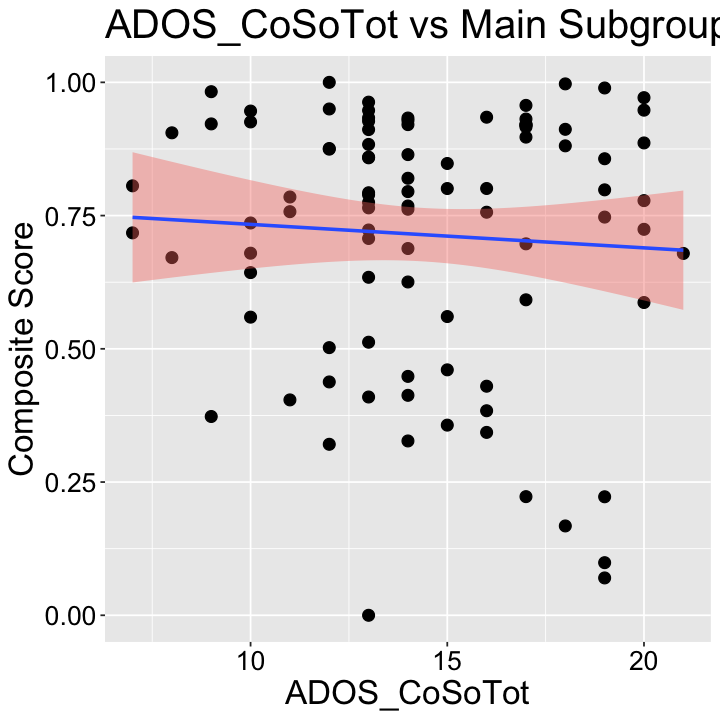

Saving 7 x 7 in image

Saving 7 x 7 in image



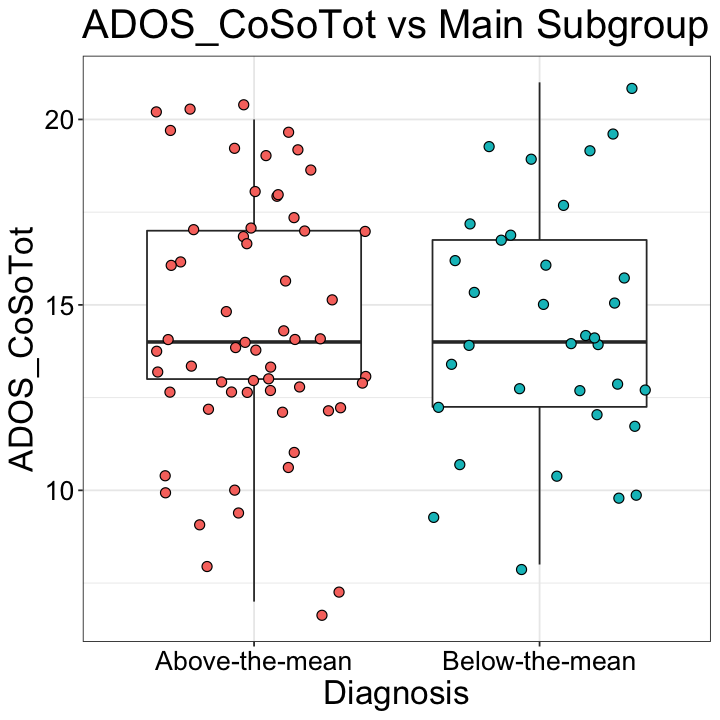

In [72]:
main_pheno_up <- read.csv("/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/main_pheno_up.csv", row.names=1)
concensus_main = dataTandM$data$concensus[dataTandM$data$concensus$group=='main',]

concensus_main$final_ADOS_CoSoTot = main_pheno_up[concensus_main$sampleName, 'final_ADOS_CoSoTot']
concensus_main$recentDxJ_dxCode = main_pheno_up[concensus_main$sampleName, 'recentDxJ_dxCode']
concensus_main$recentDxJ_ageMo = main_pheno_up[concensus_main$sampleName, 'recentDxJ_ageMo']
concensus_main$subjectID = main_pheno_up[concensus_main$sampleName, 'subjectId']
head(concensus_main)
concensus_main$sampleLabel="TD"
concensus_main$sampleLabel[concensus_main$recentDxJ_dxCode=="TD"]="TD"
# expMain$sampleLabel[concensus_main$recentDxJ_dxCode=="other"]="TD"
mean(concensus_main$weightedEstimate[concensus_main$recentDxJ_dxCode=="ASD"])
print('mean')
print(mean(concensus_main$weightedEstimate[concensus_main$recentDxJ_dxCode=="ASD"]))
the_mean = mean(concensus_main$weightedEstimate[concensus_main$recentDxJ_dxCode=="ASD"])
# the_mean = 0.75
concensus_main$sampleLabel[concensus_main$recentDxJ_dxCode=="ASD"&concensus_main$weightedEstimate>=the_mean]="Above-the-mean"
concensus_main$sampleLabel[concensus_main$recentDxJ_dxCode=="ASD"&concensus_main$weightedEstimate<the_mean]="Below-the-mean"
write.table(concensus_main, file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/main_consensus.csv",sep = ",")
# cor(, )

cor.test(concensus_main$weightedEstimate,concensus_main$final_ADOS_CoSoTot,use="complete.obs") 

inputPath = "/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"
# pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_MainSubgroup_corr.pdf"),width = 3.5, height = 4)
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(concensus_main[concensus_main$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(as.numeric(final_ADOS_CoSoTot),weightedEstimate, fill=recentDxJ_dxCode))+
  geom_point(size=3)+
  geom_smooth(method = "lm")+
  labs(title='Eval', x = "ADOS_CoSoTot", y='Composite Score')+
  ggtitle("ADOS_CoSoTot vs Main Subgroup")+
  theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_MainSubgroup_corr.pdf"))
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_MainSubgroup_corr.png"))
# pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_MainSubgroup_box.pdf"),width = 3.5, height = 4)


options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(concensus_main[concensus_main$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(sampleLabel,as.numeric(final_ADOS_CoSoTot)))+
  geom_boxplot(outlier.shape = NA)+theme_bw()+
geom_jitter(aes(fill=factor(sampleLabel)), width = 0.4,shape=21,size=2.5)+
ggtitle("ADOS_CoSoTot vs Main Subgroup")+
theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))+xlab("Diagnosis")+ylab("ADOS_CoSoTot") 
# dev.off()
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_MainSubgroup_box.png"))
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_MainSubgroup_box.pdf"))


,sampleName,weightedEstimate,real,group
,<chr>,<dbl>,<dbl>,<chr>
1,100,0.7262076,1,test
3,102,0.1368303,0,test
4,104,0.3231128,0,test
5,105,0.2522151,0,test
24,129,0.2190659,0,test
25,13,0.8479194,1,test


[1] 0.7142184


	Pearson's product-moment correlation

data:  concensus_test$weightedEstimate and concensus_test$final_ADOS_CoSoTot
t = 4.0687, df = 63, p-value = 0.000134
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2388364 0.6299728
sample estimates:
      cor 
0.4561631 


`geom_smooth()` using formula 'y ~ x'

Saving 7 x 7 in image

`geom_smooth()` using formula 'y ~ x'

Saving 7 x 7 in image

`geom_smooth()` using formula 'y ~ x'



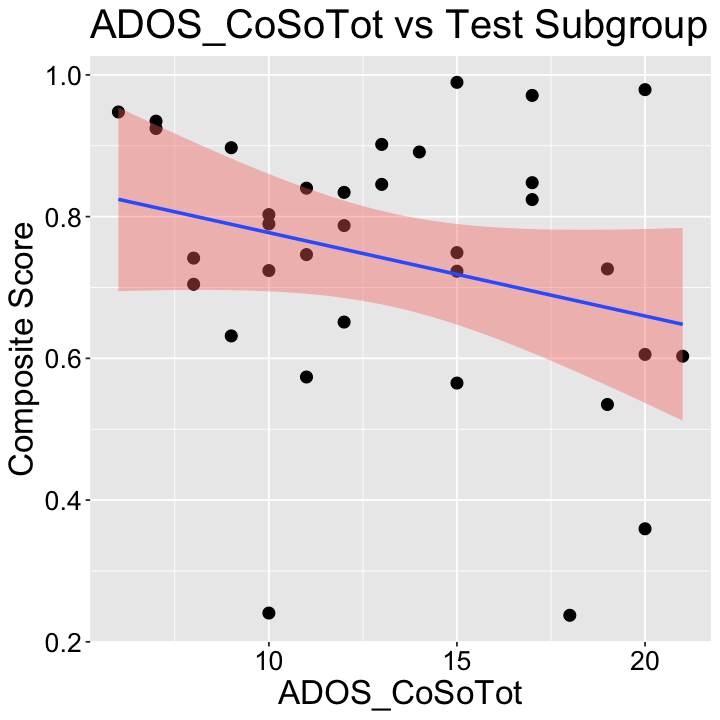

Saving 7 x 7 in image

Saving 7 x 7 in image



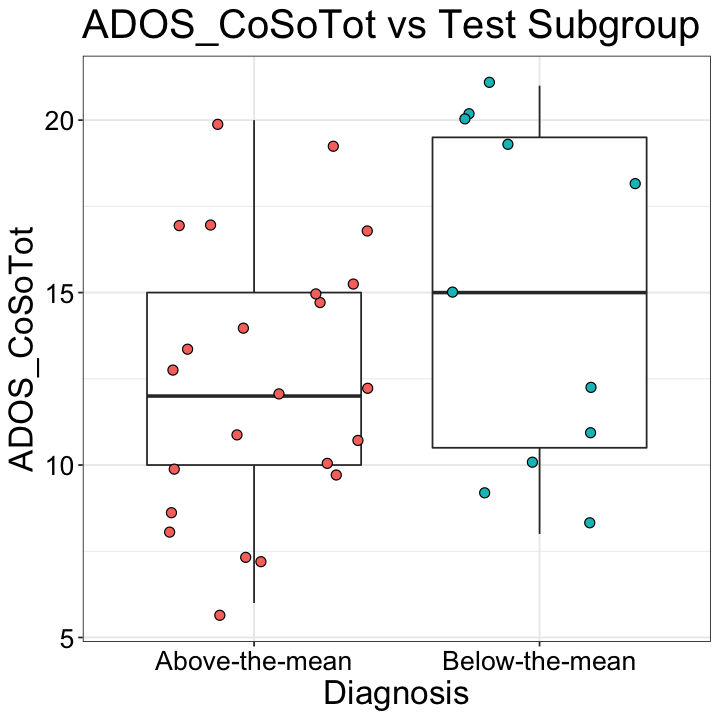

In [73]:
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/out1/data.rda")
write.table(data[["testInputData"]]@phenoData@data, file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/test_pheno.csv",sep = ",")

concensus_test = dataTandM$data$concensus[dataTandM$data$concensus$group=='test',]
head(concensus_test)

test_pheno_up <- read.csv("/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/test_pheno_up.csv", row.names=1)
concensus_test$final_ADOS_CoSoTot = test_pheno_up[concensus_test$sampleName, 'final_ADOS_CoSoTot']

concensus_test$recentDxJ_dxCode = test_pheno_up[concensus_test$sampleName, 'recentDxJ_dxCode']
concensus_test$recentDxJ_ageMo = test_pheno_up[concensus_test$sampleName, 'recentDxJ_ageMo']
concensus_test$subjectID = test_pheno_up[concensus_test$sampleName, 'subjectId']
# head(concensus_test)
concensus_test$sampleLabel="TD"
concensus_test$sampleLabel[concensus_test$recentDxJ_dxCode=="TD"]="TD"
# expMain$sampleLabel[concensus_main$recentDxJ_dxCode=="other"]="TD"
the_mean
concensus_test$sampleLabel[concensus_test$recentDxJ_dxCode=="ASD"&concensus_test$weightedEstimate>=the_mean]="Above-the-mean"
concensus_test$sampleLabel[concensus_test$recentDxJ_dxCode=="ASD"&concensus_test$weightedEstimate<the_mean]="Below-the-mean"

write.table(concensus_test, file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/test_consensus.csv",sep = ",")
cor.test(concensus_test$weightedEstimate,concensus_test$final_ADOS_CoSoTot,use="complete.obs") 
###############


# pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_corr.pdf"),width = 3.5, height = 4)
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(concensus_test[concensus_test$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(as.numeric(final_ADOS_CoSoTot),weightedEstimate, fill=recentDxJ_dxCode))+
  geom_point(size=3)+
  geom_smooth(method = "lm")+
  labs(title='Eval', x = "ADOS_CoSoTot", y='Composite Score')+
  ggtitle("ADOS_CoSoTot vs Test Subgroup")+
  theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))
# dev.off()
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_corr.png"))
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_corr.pdf"))

# pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_box.pdf"),width = 3.5, height = 4)
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(concensus_test[concensus_test$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(sampleLabel,as.numeric(final_ADOS_CoSoTot)))+
  geom_boxplot(outlier.shape = NA)+theme_bw()+
geom_jitter(aes(fill=factor(sampleLabel)), width = 0.4,shape=21,size=2.5)+
ggtitle("ADOS_CoSoTot vs Test Subgroup")+
theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))+xlab("Diagnosis")+ylab("ADOS_CoSoTot") 
# dev.off()
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_box.png"))
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_box.pdf"))


`geom_smooth()` using formula 'y ~ x'

Saving 7 x 7 in image

`geom_smooth()` using formula 'y ~ x'



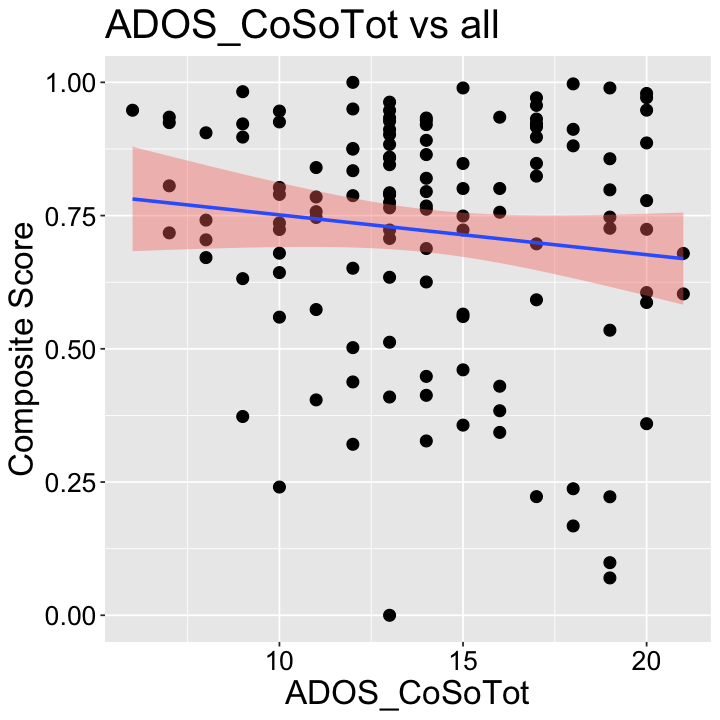

Saving 7 x 7 in image

Saving 7 x 7 in image



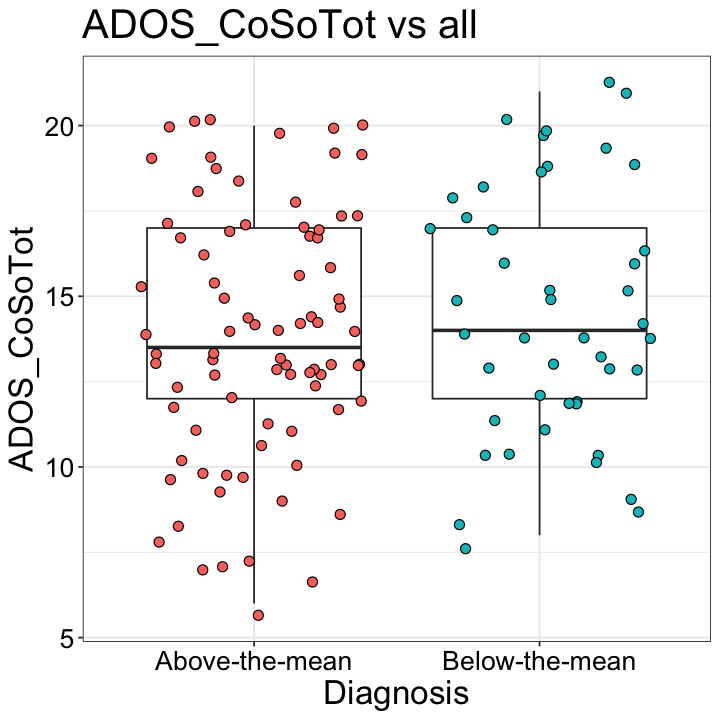

In [74]:
concensus_all=rbind(concensus_main, concensus_test)
# pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_corr.pdf"),width = 3.5, height = 4)
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(concensus_all[concensus_all$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(as.numeric(final_ADOS_CoSoTot),weightedEstimate, fill=recentDxJ_dxCode))+
  geom_point(size=3)+
  geom_smooth(method = "lm")+
  labs(title='Eval', x = "ADOS_CoSoTot", y='Composite Score')+
  ggtitle("ADOS_CoSoTot vs all")+
  theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))
# dev.off()
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_corr.png"))

# pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_box.pdf"),width = 3.5, height = 4)
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(concensus_all[concensus_all$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(sampleLabel,as.numeric(final_ADOS_CoSoTot)))+
  geom_boxplot(outlier.shape = NA)+theme_bw()+
geom_jitter(aes(fill=factor(sampleLabel)), width = 0.4,shape=21,size=2.5)+
ggtitle("ADOS_CoSoTot vs all")+
theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))+xlab("Diagnosis")+ylab("ADOS_CoSoTot") 
# dev.off()
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_all_box.pdf"))
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_all_box.png"))

[1] 0.7142184

Saving 7 x 7 in image

Saving 7 x 7 in image



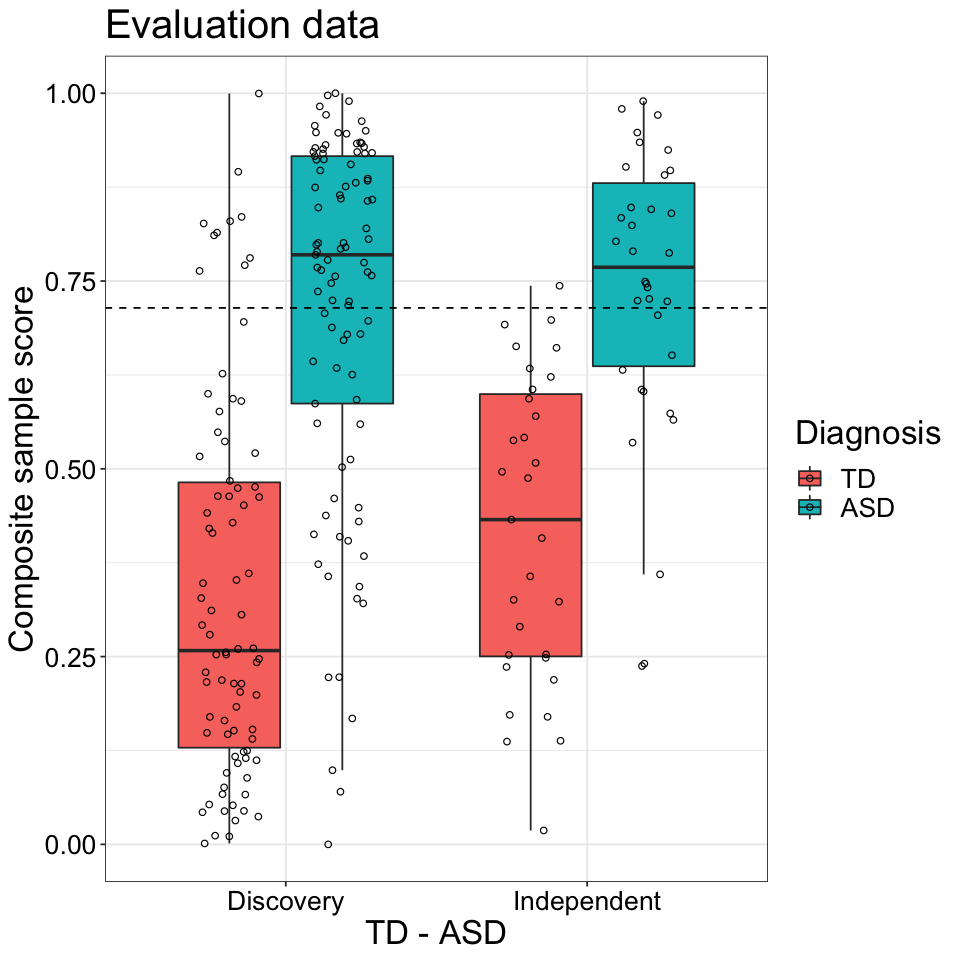

In [75]:
the_lint = mean(concensus_main$weightedEstimate[concensus_main$recentDxJ_dxCode=="ASD"])
the_lint
options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(dataTandM$data$concensus,aes(fill=factor(real),y=weightedEstimate, x=group), )+
  geom_boxplot(outlier.shape = NA)+
  theme_bw()+geom_hline(yintercept = the_lint,linetype='dashed')+
  # geom_jitter(width = 0.2, alpha=0.6, shape=21)+
  geom_point(position=position_jitterdodge(dodge.width=0.75), shape=1)+
  ggtitle("Evaluation data")+
  theme(legend.position = "right", axis.text = element_text(color="black"), text = element_text(size = 20))+
  labs(x="TD - ASD",  y="Composite sample score")+
  scale_fill_discrete(name='Diagnosis', labels=c('TD','ASD'))+
  scale_x_discrete(labels=c("Discovery", "Independent"))

ggsave(paste0(inputPath, "Figure2_c.pdf"))
ggsave(paste0(inputPath, "Figure2_c.png"))

ERROR: Error in eval(expr, envir, enclos): object 'the_output_table' not found


In [76]:
the_output_table = dataTandM$data$concensus
# sum(the_output_table[the_output_table$real == 1,]$weightedEstimate>0.714)
sum(the_output_table[the_output_table$real == 1 & the_output_table$group == 'main',]$weightedEstimate<=0.714)
sum(the_output_table[the_output_table$real == 1 & the_output_table$group == 'main',]$weightedEstimate>=0.714)
nrow(the_output_table[the_output_table$real == 0 & the_output_table$group == 'main',])
# sum(the_output_table[the_output_table$real == 0,]$weightedEstimate>0.714)
# sum(the_output_table[the_output_table$real == 0,]$weightedEstimate<=0.714)

82/(82+45)
11/(11+102)
# sum(the_output_table[the_output_table$group =='main',]$weightedEstimate>0.714)

[1] 34

[1] 59

[1] 82

[1] 0.6456693

[1] 0.09734513

In [77]:
write.table(dataTandM$data$concensus, paste0(inputPath, 'main_test_ensemble_score.csv'), sep=",")

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



pdf 
  2

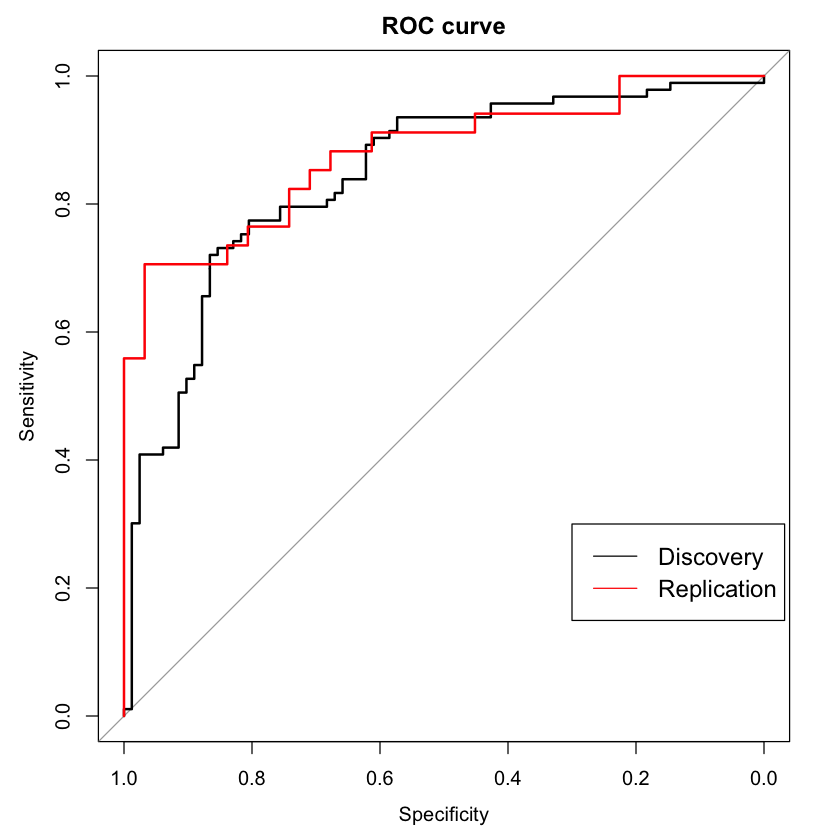

In [78]:
#AU-ROC of the composite scores
dMain = dataTandM$data$concensus[which(dataTandM$data$concensus$group=='main'),]
tMain = dataTandM$data$concensus[which(dataTandM$data$concensus$group=='test'),]
Mainvis=.myClassificationEvaluationFn(dMain$weightedEstimate,dMain$real)
options(repr.plot.width = 7, repr.plot.height = 7)
plot(Mainvis$ROCdata,xlim=c(1,0),ylim=c(0,1),main="ROC curve",col='black')
# dev.off()
# pdf(file=paste0(inputPath,"test_roc.pdf"))
Testvis=.myClassificationEvaluationFn(tMain$weightedEstimate,tMain$real)
lines(Testvis$ROCdata,xlim=c(1,0),ylim=c(0,1),col="red")
legend(0.3, 0.3, legend=c("Discovery", "Replication"),
       col=c("black", "red"), lty=c(1,1), cex=1.2)
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"
options(repr.plot.width = 6, repr.plot.height = 6)

pdf(file=paste0(inputPath,"figroc_curve.pdf"))
dMain = dataTandM$data$concensus[which(dataTandM$data$concensus$group=='main'),]
tMain = dataTandM$data$concensus[which(dataTandM$data$concensus$group=='test'),]
Mainvis = .myClassificationEvaluationFn(dMain$weightedEstimate,dMain$real)

plot(Mainvis$ROCdata,xlim=c(1,0),ylim=c(0,1),main="ROC curve",col='black')
# dev.off()
# pdf(file=paste0(inputPath,"test_roc.pdf"))
Testvis=.myClassificationEvaluationFn(tMain$weightedEstimate,tMain$real)
lines(Testvis$ROCdata,xlim=c(1,0),ylim=c(0,1),col="red")
legend(0.3, 0.3, legend=c("Discovery", "Replication"),
       col=c("black", "red"), lty=c(1,1), cex=1.2)
dev.off()

### Prenatal event

In [79]:
library(readxl)
my_data_1 <- read_excel("/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/prenatalData_Bokan_mainConsensus_subjects.xlsx")
my_data_2 <- read_excel("/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/prenatalData_Bokan_testConsensus_subjects.xlsx")

In [80]:
head(my_data_1)

FormSerialId,EvalDate,SubjectId,P2F2,DOB,AgeMo,Sex,PregProb,FertDrugsNY,FertDrugs,⋯,UnusExpln,BrthWt_lb,BrthWt_oz,BrthLen_in,BrthHC_cm,Apgar1min,Apgar5min,HospStay,Prob1stMosNY,Prob1stMosExp
<chr>,<chr>,<chr>,<chr>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
PNB-00006,39584,R8S6F,MASI,2005-11-02,30.422999999999998,M,N,N,NULL,⋯,NULL,9,4,20,NULL,NULL,NULL,3,Y,Many colds- 2 yr old brother at home.
PNB-00009,39688,S4X9Y,ZEHU,2007-04-05,16.789000000000001,M,N,N,NULL,⋯,C-section after pushing for 3 hours. He wasn't in the birth canal straight+ got fever.,7,14,19,14,NULL,NULL,2,Y,"Jaundice, but not too bad. We didn't need to use the light."
PNB-00014,39549,E6E9P,CORE,2005-10-20,29.7,M,N,N,NULL,⋯,NULL,NULL,22,NULL,NULL,NULL,NULL,NULL,Y,"Jaundice, fever, weight loss, later developed laryngomalacia and birth mark like rash on R cheek"
PNB-00015,39834,Q2P7E,SALA,2007-08-14,17.280999999999999,M,-,-,NULL,⋯,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,-,NULL
PNB-00016,39541,M4L5B,MASA,2006-09-08,18.824999999999999,M,Y,Y,Injectable and cloned,⋯,NULL,6,14,20,NULL,8,9,3,N,NULL
PNB-00017,39825,P8M2M,OLHO,2006-10-31,26.414999999999999,M,Y,Y,IVF,⋯,please see NICU d/c summary,6,5,49.5,34,6,8,3,Y,NULL


In [81]:
head(concensus_main)

,sampleName,weightedEstimate,real,group,final_ADOS_CoSoTot,recentDxJ_dxCode,recentDxJ_ageMo,subjectID,sampleLabel
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<fct>,<chr>
2,101,0.7471575,1,main,19,ASD,34.366,X3F5T,Above-the-mean
6,106,0.3729955,1,main,9,ASD,40.542,H3E8D,Below-the-mean
7,107,0.3208587,1,main,12,ASD,120.000,C2K6H,Below-the-mean
8,109,0.5998958,0,main,2,TD,34.825,Y2P2Z,TD
9,110,0.4633807,0,main,1,TD,15.244,H7U8Q,TD
10,111,0.9113812,1,main,13,ASD,30.292,M8K5X,Above-the-mean


In [82]:
prenatal = rbind(my_data_1, my_data_2)
# prenatal = my_data_1

the_mean = mean(concensus_main[concensus_main$recentDxJ_dxCode=="ASD",]$weightedEstimate)
# the_mean
# the_mean =0.74
sum(concensus_main$weightedEstimate>the_mean & concensus_main$real==0)
bloodId=concensus_main$sampleName
sampleNames=concensus_main$subjectID
scores=concensus_main$weightedEstimate
DX=concensus_main$real
df=data.frame(bloodId=bloodId,sampleNames=sampleNames,scores=scores,dx=DX,stringsAsFactors = F)
rm(sampleNames,scores,DX)
bloodId=concensus_test$sampleName
sampleNames=concensus_test$subjectID
scores=concensus_test$weightedEstimate
DX=concensus_test$real
df=rbind(df,data.frame(bloodId=bloodId,sampleNames=sampleNames,scores=scores,dx=DX,stringsAsFactors = F))

dim(df)

df=merge(df, prenatal, by.x="sampleNames", by.y="SubjectId")
df$category="other"
df$category[df$dx==0]="TD"
df$category[df$dx==1&df$scores>=the_mean]="above"
df$category[df$dx==1&df$scores<the_mean]="below"

# df=my_data_3
# df = as.data.frame(df)
# table(df$LocAnes)
df$Hosp_tri=gsub("-",NA,df$Hosp_tri)
df$Hosp_tri = gsub("NULL",NA,df$Hosp_tri)
df$Hosp_med=gsub("-",NA,df$Hosp_med)
df$Hosp_med = gsub("NULL",NA,df$Hosp_med)
df$Surgery_tri=gsub("-",NA,df$Surgery_tri)
df$Surgery_tri = gsub("NULL",NA,df$Surgery_tri)

df$Surgery_med[which(df$Surgery_med=="C-section")]=NA
df$Surgery_med[which(df$Surgery_med=="c-section, vicadin (2 weeks)")]=NA
df$Surgery_med=gsub("-",NA,df$Surgery_med)
df$Surgery_med = gsub("NULL",NA,df$Surgery_med)

df$WtLoss_tri=gsub("-",NA,df$WtLoss_tri)
df$WtLoss_tri = gsub("NULL",NA,df$WtLoss_tri)
df$WtLoss_med=gsub("-",NA,df$WtLoss_med)
df$WtLoss_med=gsub("none",NA,df$WtLoss_med)
df$WtLoss_med=gsub("None",NA,df$WtLoss_med)
df$WtLoss_med = gsub("NULL",NA,df$WtLoss_med)
df$GenAnes=gsub("-",NA,df$GenAnes)
df$GenAnes=gsub("N",NA,df$GenAnes)
df$GenAnes = gsub("NULL",NA,df$GenAnes)
df$ConfBed_med=gsub("-",NA,df$ConfBed_med)
df$ConfBed_med=gsub("none",NA,df$ConfBed_med)
df$ConfBed_med=gsub("none, bedrest",NA,df$ConfBed_med)
df$ConfBed_med = gsub("NULL",NA,df$ConfBed_med)
df$ConfBed_tri=gsub("-",NA,df$ConfBed_tri)
df$ConfBed_tri = gsub("NULL",NA,df$ConfBed_tri)
df$LocAnes=gsub("N",NA,df$LocAnes)
df$LocAnes=gsub("-",NA,df$LocAnes)
df$LocAnes = gsub("NULL",NA,df$LocAnes)
df$MornSick_med = gsub("none",NA,df$MornSick_med)
df$MornSick_med = gsub("None",NA,df$MornSick_med)
df$MornSick_med = gsub("n/a",NA,df$MornSick_med)
df$MornSick_med = gsub("N/A",NA,df$MornSick_med)
df$MornSick_med = gsub("no",NA,df$MornSick_med)
df$MornSick_med = gsub("-",NA,df$MornSick_med)
df$MornSick_med = gsub("N",NA,df$MornSick_med)
df$MornSick_med = gsub("NULL",NA,df$MornSick_med)
df$MornSick_med = gsub("-",NA,df$MornSick_med)

df$MornSick_tri = gsub("-",NA,df$MornSick_tri)
df$MornSick_tri = gsub("NULL",NA,df$MornSick_tri)

df$Nausea_tri= gsub("-",NA,df$Nausea_tri)
df$Nausea_tri = gsub("NULL",NA,df$Nausea_tri)
df$Nausea_med= gsub("-",NA,df$Nausea_med)
df$Nausea_med = gsub("NULL",NA,df$Nausea_med)
df$Swell_tri= gsub("-",NA,df$Swell_tri)
df$Swell_tri = gsub("NULL",NA,df$Swell_tri)

[1] 10

[1] 240   4

In [83]:
df

sampleNames,bloodId,scores,dx,FormSerialId,EvalDate,P2F2,DOB,AgeMo,Sex,⋯,BrthWt_lb,BrthWt_oz,BrthLen_in,BrthHC_cm,Apgar1min,Apgar5min,HospStay,Prob1stMosNY,Prob1stMosExp,category
<fct>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dttm>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
A2H7X,4807135042_B,0.73611200,1,PNB-01001,39751,HUAB,2006-12-11,22.637,F,⋯,6,7,20,31,9,9,1,Y,Jaundice - Hunter had jaundice for 5 days.,above
A2Y4H,223,0.92570574,1,PNB-01153,40287,DEAR,2007-05-12,35.253,M,⋯,6,NULL,NULL,NULL,NULL,NULL,28,Y,Was on heart monitor for first month for apnea and jaundice,above
A3W6D,68,0.56513398,1,PNB-00048,1226448000,OLSE,2007-08-28,14.522,M,⋯,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,below
A5G5M,80,0.84013101,1,PNB-00013,1233273600,BEED,2006-06-03,31.934,M,⋯,6,2,19.5,NULL,NULL,NULL,3,N,NULL,above
A5M2D,13,0.84791940,1,PNB-01012,1205971200,AUBA,2005-07-11,32.296,M,⋯,7,4,19,NULL,NULL,NULL,3,Y,"occasional unconsolable crying days after, no crying immediately after birth, color not good 1st day",above
A6L7X,25,0.78738061,1,PNB-01058,1210896000,DASO,2005-12-05,29.339,M,⋯,3,5,15.5,NULL,NULL,NULL,56,Y,"reflux, feeding tube, oxygen - CPAP, could not suck/swallow/breathe",above
A9P5P,363,0.32788881,0,PNB-10097,40665,KEMO,2009-12-30,16.033000000000001,M,⋯,3,11,NULL,NULL,NULL,NULL,54,Y,"breathing problems, reflex kidneys",TD
B2J9W,135,0.70705691,1,PNB-00130,40059,DACO,2008-03-26,17.280999999999999,M,⋯,7,2,NULL,NULL,NULL,NULL,3,Y,Jaundice horas despues de nacer,below
B4C2A,168,0.07591256,0,pnb-00121,40141,MAJE,2008-11-02,12.715,M,⋯,7,11,21,NULL,NULL,NULL,2,N,NULL,TD


In [84]:
sum(df$dx==1 & df$scores>=the_mean)

[1] 79

In [85]:
df = df[,c('sampleNames','category','Hosp_tri', 'Surgery_tri', 'ConfBed_tri', 'GenAnes', 'Nausea_tri','MornSick_tri','Swell_tri')]
df

sampleNames,category,Hosp_tri,Surgery_tri,ConfBed_tri,GenAnes,Nausea_tri,MornSick_tri,Swell_tri
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
A2H7X,above,NA,NA,NA,NA,NA,NA,3
A2Y4H,above,NA,NA,NA,NA,NA,1,NA
A3W6D,below,NA,NA,NA,NA,NA,NA,NA
A5G5M,above,NA,NA,NA,NA,NA,1,NA
A5M2D,above,NA,NA,NA,Y,3,3,NA
A6L7X,above,NA,3,3,NA,NA,1,NA
A9P5P,TD,NA,NA,NA,Y,NA,NA,NA
B2J9W,below,NA,NA,NA,NA,NA,NA,NA
B4C2A,TD,NA,NA,NA,Y,NA,1,NA


In [86]:
a_table = data.frame(col=c('above-the-mean','below-the-mean','TD'))#c('good','poor','TD'))
a_table$concensus = table(df$category)
t_positive = c()
t_negative = c()
for(i in row.names(df)){
if(sum(!is.na(df[i, c('Hosp_tri', 'Surgery_tri','ConfBed_tri','GenAnes')]))==0){
    t_positive=c(t_positive, 'NULL')
}
    else{
        t_positive=c(t_positive, 1)
    }
if(sum(!is.na(df[i, c('Nausea_tri','MornSick_tri','Swell_tri')]))==0){
    t_negative=c(t_negative, 'NULL')
}
    else{
        t_negative=c(t_negative, 1)
    }    
}
df$t_p = t_positive
df$t_n = t_negative

In [87]:
prenatal_concensuse = merge(df, concensus_all, by.x="sampleNames", by.y="subjectID")
prenatal_concensuse

sampleNames,category,Hosp_tri,Surgery_tri,ConfBed_tri,GenAnes,Nausea_tri,MornSick_tri,Swell_tri,t_p,t_n,sampleName,weightedEstimate,real,group,final_ADOS_CoSoTot,recentDxJ_dxCode,recentDxJ_ageMo,sampleLabel
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<chr>
A2H7X,above,NA,NA,NA,NA,NA,NA,3,NULL,1,4807135042_B,0.73611200,1,main,10,ASD,22.899,Above-the-mean
A2Y4H,above,NA,NA,NA,NA,NA,1,NA,NULL,1,223,0.92570574,1,main,10,ASD,35.483,Above-the-mean
A3W6D,below,NA,NA,NA,NA,NA,NA,NA,NULL,NULL,68,0.56513398,1,test,15,ASD,36.205,Below-the-mean
A5G5M,above,NA,NA,NA,NA,NA,1,NA,NULL,1,80,0.84013101,1,test,11,ASD,32.066,Above-the-mean
A5M2D,above,NA,NA,NA,Y,3,3,NA,1,1,13,0.84791940,1,test,17,ASD,32.526,Above-the-mean
A6L7X,above,NA,3,3,NA,NA,1,NA,1,1,25,0.78738061,1,test,12,ASD,43.598,Above-the-mean
A9P5P,TD,NA,NA,NA,Y,NA,NA,NA,1,NULL,363,0.32788881,0,main,2,TD,47.376,TD
B2J9W,below,NA,NA,NA,NA,NA,NA,NA,NULL,NULL,135,0.70705691,1,main,13,ASD,34.760,Below-the-mean
B4C2A,TD,NA,NA,NA,Y,NA,1,NA,1,1,168,0.07591256,0,main,5,TD,31.540,TD


In [88]:
for(term in c('Hosp_tri', 'Surgery_tri','ConfBed_tri', 'GenAnes',
                'Nausea_tri','MornSick_tri','Swell_tri','t_p','t_n')){
  print(term)
  print(table(df[,term], df$category))
  temp_table = table(df[,term],df$category)
  head(temp_table)
  a_vex=c()
  for(dx in c('above','below','TD')){
    temp_col = temp_table[,dx]
    if (dim(temp_table)[1]==1){
      a_vex = c(a_vex,temp_col)
    }
  else{
    temp_col = temp_col[names(temp_col)!='NULL']
    a_vex = c(a_vex, sum(temp_col))
    }
}
  print(a_vex)
  a_table[,term] = a_vex
}

[1] "Hosp_tri"
   
    above below TD
  1     0     1  1
  2     0     1  2
  3     5     3  3
[1] 5 5 6
[1] "Surgery_tri"
   
    above below TD
  1     0     1  1
  2     0     2  1
  3     1     0  2
[1] 1 3 4
[1] "ConfBed_tri"
   
    above below TD
  1     0     0  1
  2     3     3  4
  3     5     5  4
[1] 8 8 9
[1] "GenAnes"
   
    above below TD
  Y    10    11 10
[1] 10 11 10
[1] "Nausea_tri"
   
    above below TD
  1     4     0  7
  2     0     0  3
  3     1     1  2
[1]  5  1 12
[1] "MornSick_tri"
   
    above below TD
  1    40    17 62
  2     2     0  1
  3     1     0  1
[1] 43 17 64
[1] "Swell_tri"
   
    above below TD
  1     0     1  2
  2     2     0  3
  3    21     9 21
[1] 23 10 26
[1] "t_p"
      
       above below TD
  1       20    19 24
  NULL    59    26 83
[1] 20 19 24
[1] "t_n"
      
       above below TD
  1       53    23 70
  NULL    26    22 37
[1] 53 23 70


In [89]:
a_table

col,concensus,Hosp_tri,Surgery_tri,ConfBed_tri,GenAnes,Nausea_tri,MornSick_tri,Swell_tri,t_p,t_n
<fct>,<table>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
above-the-mean,79,5,1,8,10,5,43,23,20,53
below-the-mean,45,5,3,8,11,1,17,10,19,23
TD,107,6,4,9,10,12,64,26,24,70


In [90]:
a = 19
b = 20
c = 24
a1 = 79
b1 = 45
c1 = 107
fisher.test(rbind(c(a1-a, b1-b), c(a,b)))
fisher.test(rbind(c(a1-a, c1-c), c(a,c)))
fisher.test(rbind(c(c1-c, b1-b), c(c,b)))


	Fisher's Exact Test for Count Data

data:  rbind(c(a1 - a, b1 - b), c(a, b))
p-value = 0.02655
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.071750 5.935452
sample estimates:
odds ratio 
  2.506221 



	Fisher's Exact Test for Count Data

data:  rbind(c(a1 - a, c1 - c), c(a, c))
p-value = 0.8609
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4351499 1.9367093
sample estimates:
odds ratio 
  0.913575 



	Fisher's Exact Test for Count Data

data:  rbind(c(c1 - c, b1 - b), c(c, b))
p-value = 0.01027
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.225115 6.190600
sample estimates:
odds ratio 
  2.746235 


# data tests for geo pref

In [91]:
library(readxl)

my_data_geo <- read_excel("/Volumes/Work/Autism/master_spread_sheet/Final GeoPref MasterSheet.xlsx", sheet='CompiledGeoPref_LongWide')


Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting numeric in NV2713 / R2713C386: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting numeric in NZ2713 / R2713C390: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting numeric in OB2713 / R2713C392: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting numeric in OD2713 / R2713C394: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting date in OE2713 / R2713C395: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting numeric in PT2713 / R2713C436: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting date in PX2713 / R2713C440: got 'NULL'”
Warning message in 

In [92]:
the_geo_Table = my_data_geo[,c('Subject ID',"1ST_GOOD/OTHER_TIMEPOINT/EXCLUDE", "Total Fixation Duration",'% Fixation Geo')]
colnames(the_geo_Table) = c('subjectId', 'times', 'total','geo_per')

In [93]:
write.table(concensus_all, paste0(inputPath, "consensus.csv"), sep = ',')

In [94]:
concensus_all = rbind(concensus_main, concensus_test)
ddd = the_geo_Table[the_geo_Table$times =='1ST_GOOD',]
dddd = merge(ddd, concensus_all, by.x="subjectId", by.y="subjectID")
dddd

subjectId,times,total,geo_per,sampleName,weightedEstimate,real,group,final_ADOS_CoSoTot,recentDxJ_dxCode,recentDxJ_ageMo,sampleLabel
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<chr>
A2Y4H,1ST_GOOD,61.39,51.848835,223,0.92570574,1,main,10,ASD,35.483,Above-the-mean
A3W6D,1ST_GOOD,54.14,3.380126,68,0.56513398,1,test,15,ASD,36.205,Below-the-mean
A5G5M,1ST_GOOD,56.09,78.035300,80,0.84013101,1,test,11,ASD,32.066,Above-the-mean
A9P5P,1ST_GOOD,59.26,3.914951,363,0.32788881,0,main,2,TD,47.376,TD
B2J9W,1ST_GOOD,48.11,43.275826,135,0.70705691,1,main,13,ASD,34.760,Below-the-mean
B4C2A,1ST_GOOD,56.89,65.459659,168,0.07591256,0,main,5,TD,31.540,TD
B4J4L,1ST_GOOD,50.34,21.911005,4807135024_E,0.41452215,0,main,2,TD,44.715,TD
B4V3N,1ST_GOOD,46.34,36.167458,275,0.63420422,1,main,13,ASD,31.639,Below-the-mean
B4Z9C,1ST_GOOD,35.22,24.247587,249,0.25285157,0,test,0,TD,37.749,TD


Saving 7 x 7 in image



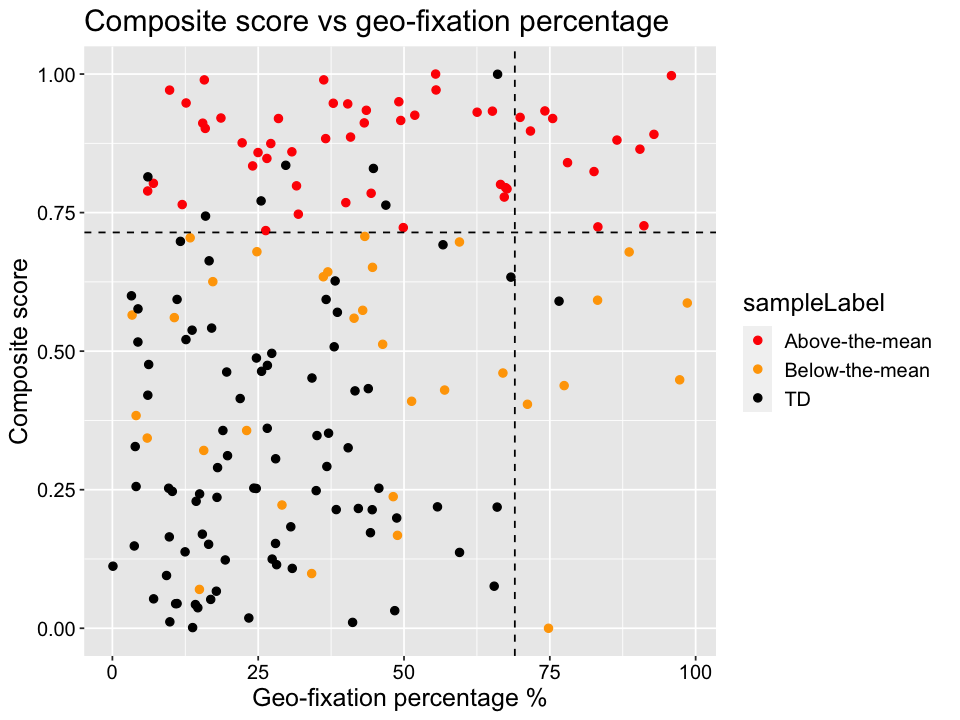

In [95]:
options(repr.plot.width = 8, repr.plot.height = 6)
ggplot(dddd[dddd$recentDxJ_dxCode %in% c("ASD",'TD'),],aes(x=geo_per, y=weightedEstimate, color=sampleLabel))+
# scale_fill_discrete()+
#   geom_smooth(method = "lm")+
   geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Geo-fixation percentage %", y='Composite score')+
  ggtitle("Composite score vs geo-fixation percentage")+
  geom_hline(yintercept = the_mean,linetype='dashed')+
  geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
  theme(legend.position = "right",axis.text = element_text(color="black"),text = element_text(size = 15))
ggsave(paste0(inputPath,"Composite_score_vs_geo_fixation_percentage.pdf"))


In [96]:
dddd$geo_weighted = dddd$weightedEstimate
dddd$geo_weighted[dddd$geo_per>69]=1

In [97]:
.myClassificationEvaluationFn(dddd$weightedEstimate,dddd$real)
.myClassificationEvaluationFn(dddd$geo_weighted,dddd$real)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8546014

$PR
[1] 0.8418462

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 89 controls (testLabels 0) < 84 cases (testLabels 1).
Area under the curve: 0.8546

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8418462 

    Area under curve (Davis & Goadrich):
     0.8416013 

    Curve not computed ( can be done by using curve=TRUE )


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8809524

$PR
[1] 0.8756189

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 89 controls (testLabels 0) < 84 cases (testLabels 1).
Area under the curve: 0.881

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8756189 

    Area under curve (Davis & Goadrich):
     0.8756137 

    Curve not computed ( can be done by using curve=TRUE )


In [98]:
.myClassificationEvaluationFn(dddd[dddd$group=='main', ]$geo_weighted,dddd[dddd$group=='main', ]$real)
.myClassificationEvaluationFn(dddd[dddd$group=='test', ]$geo_weighted,dddd[dddd$group=='test', ]$real)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8801843

$PR
[1] 0.879507

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 62 controls (testLabels 0) < 70 cases (testLabels 1).
Area under the curve: 0.8802

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.879507 

    Area under curve (Davis & Goadrich):
     0.8794982 

    Curve not computed ( can be done by using curve=TRUE )


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8941799

$PR
[1] 0.8759191

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 27 controls (testLabels 0) < 14 cases (testLabels 1).
Area under the curve: 0.8942

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8759191 

    Area under curve (Davis & Goadrich):
     0.8758626 

    Curve not computed ( can be done by using curve=TRUE )


In [99]:
dddd[dddd$recentDxJ_dxCode %in% c("ASD",'TD'),]

,subjectId,times,total,geo_per,sampleName,weightedEstimate,real,group,final_ADOS_CoSoTot,recentDxJ_dxCode,recentDxJ_ageMo,sampleLabel,geo_weighted
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<chr>,<dbl>
1,A2Y4H,1ST_GOOD,61.39,51.848835,223,0.92570574,1,main,10,ASD,35.483,Above-the-mean,0.92570574
2,A3W6D,1ST_GOOD,54.14,3.380126,68,0.56513398,1,test,15,ASD,36.205,Below-the-mean,0.56513398
3,A5G5M,1ST_GOOD,56.09,78.035300,80,0.84013101,1,test,11,ASD,32.066,Above-the-mean,1.00000000
4,A9P5P,1ST_GOOD,59.26,3.914951,363,0.32788881,0,main,2,TD,47.376,TD,0.32788881
5,B2J9W,1ST_GOOD,48.11,43.275826,135,0.70705691,1,main,13,ASD,34.760,Below-the-mean,0.70705691
6,B4C2A,1ST_GOOD,56.89,65.459659,168,0.07591256,0,main,5,TD,31.540,TD,0.07591256
7,B4J4L,1ST_GOOD,50.34,21.911005,4807135024_E,0.41452215,0,main,2,TD,44.715,TD,0.41452215
8,B4V3N,1ST_GOOD,46.34,36.167458,275,0.63420422,1,main,13,ASD,31.639,Below-the-mean,0.63420422
9,B4Z9C,1ST_GOOD,35.22,24.247587,249,0.25285157,0,test,0,TD,37.749,TD,0.25285157


Saving 7 x 7 in image



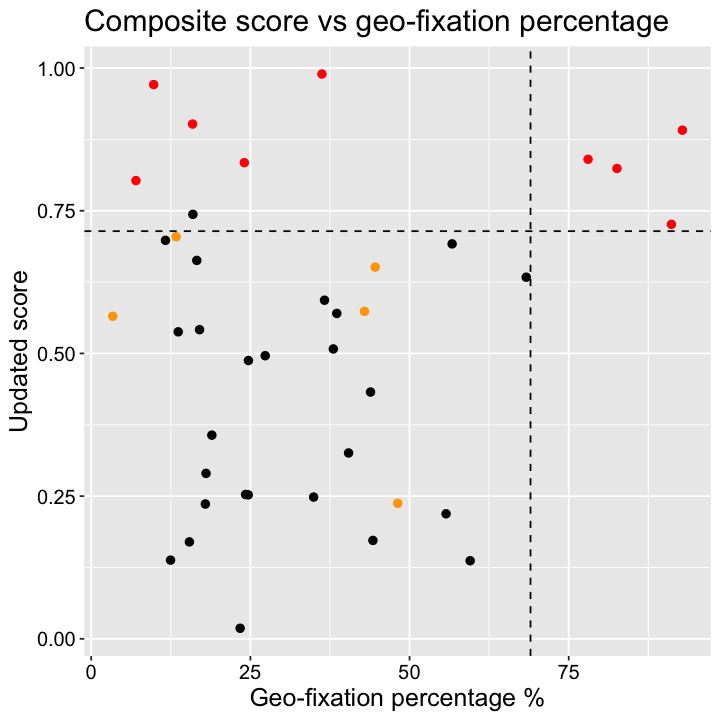

In [100]:
options(repr.plot.width = 6, repr.plot.height = 6)
dddd_test = dddd[dddd$group=='test', ]
ggplot(dddd_test[dddd_test$recentDxJ_dxCode %in% c("ASD",'TD'),],aes(x=geo_per, y=weightedEstimate, color=sampleLabel))+
# scale_fill_discrete()+
#   geom_smooth(method = "lm")+
   geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Geo-fixation percentage %", y='Updated score')+
  ggtitle("Composite score vs geo-fixation percentage")+
  geom_hline(yintercept = the_mean,linetype='dashed')+
  geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
  theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 15))
ggsave(paste0(inputPath,"Original_score_vs_geo_fixation_percentage_test.pdf"))

Saving 7 x 7 in image



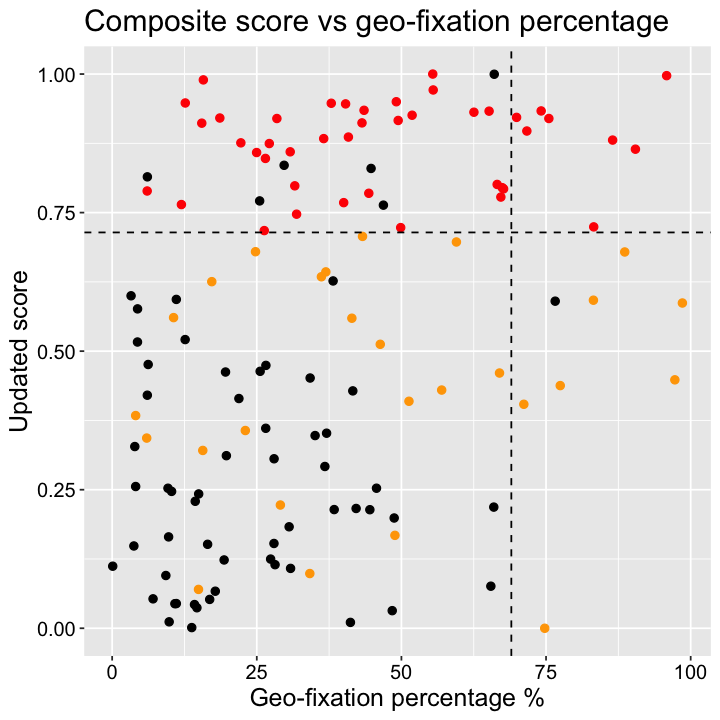

In [101]:
options(repr.plot.width = 6, repr.plot.height = 6)
dddd_main = dddd[dddd$group=='main', ]
ggplot(dddd_main[dddd_main$recentDxJ_dxCode %in% c("ASD",'TD'),],aes(x=geo_per, y=weightedEstimate, color=sampleLabel))+
# scale_fill_discrete()+
#   geom_smooth(method = "lm")+
   geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Geo-fixation percentage %", y='Updated score')+
  ggtitle("Composite score vs geo-fixation percentage")+
  geom_hline(yintercept = the_mean,linetype='dashed')+
  geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
#   theme(legend.position = "none")
  theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 15))
ggsave(paste0(inputPath,"Original_score_vs_geo_fixation_percentage_main.pdf"))

[1] 132

Saving 7 x 7 in image



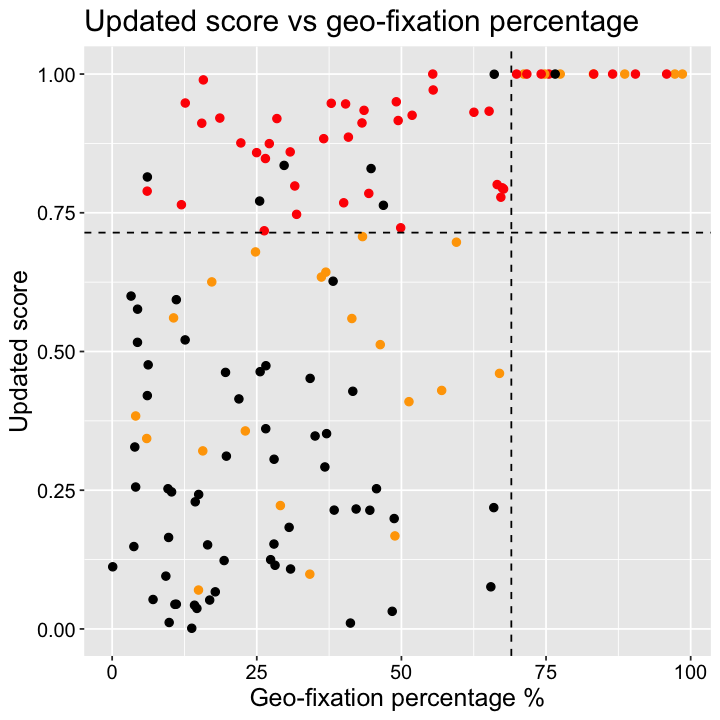

In [102]:
options(repr.plot.width = 6, repr.plot.height = 6)
dddd_main = dddd[dddd$group=='main',]
nrow(dddd_main)
ggplot(dddd_main[dddd_main$recentDxJ_dxCode %in% c("ASD",'TD'),], aes(x=geo_per, y=geo_weighted, color=sampleLabel))+
# scale_fill_discrete()+
#   geom_smooth(method = "lm")+
   geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Geo-fixation percentage %", y='Updated score')+
  ggtitle("Updated score vs geo-fixation percentage")+
  geom_hline(yintercept = the_mean,linetype='dashed')+
  geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
#   theme(legend.position = "none")
theme(legend.position = "none", axis.text = element_text(color="black"),text = element_text(size = 15))
ggsave(paste0(inputPath,"Updated_score_vs_geo_fixation_percentage_main.pdf"))

[1] 41

Saving 7 x 7 in image



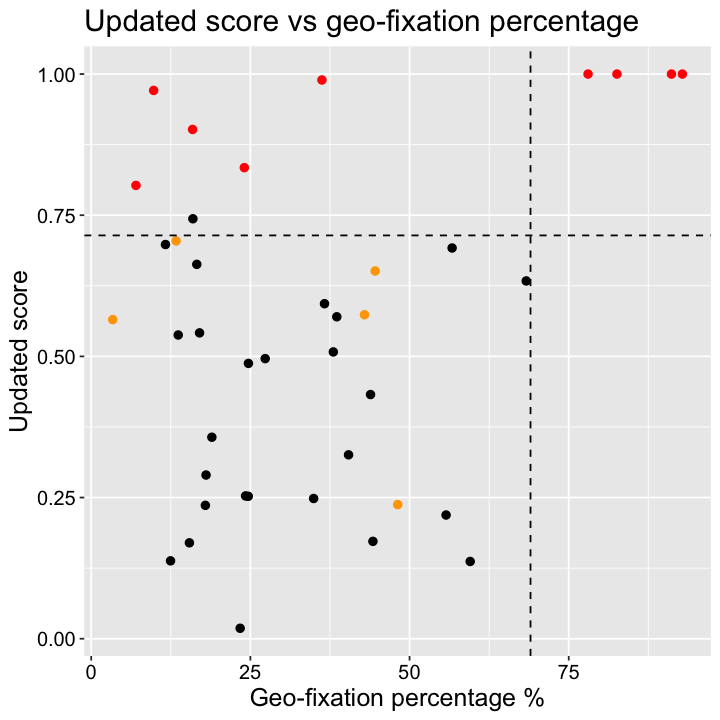

In [103]:
options(repr.plot.width = 6, repr.plot.height = 6)
dddd_test = dddd[dddd$group=='test', ]
nrow(dddd_test)
ggplot(dddd_test[dddd_test$recentDxJ_dxCode %in% c("ASD",'TD'),],aes(x=geo_per, y=geo_weighted, color=sampleLabel))+
# scale_fill_discrete()+
#   geom_smooth(method = "lm")+
   geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Geo-fixation percentage %", y='Updated score')+
  ggtitle("Updated score vs geo-fixation percentage")+
  geom_hline(yintercept = the_mean,linetype='dashed')+
  geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
#   theme(legend.position = "none")
theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 15))
ggsave(paste0(inputPath,"Updated_score_vs_geo_fixation_percentage_test.pdf"))

In [104]:
akk = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/data_classification_clinical_scores.csv')

cosmos = merge(akk, concensus_all[,c('subjectID','sampleLabel' )], by.x="subjectid", by.y="subjectID")

a = c('recentDxJ_ageMo',
      'final_ados_CoSoTot',
      'final_ados_RRTot',
      'final_ados_CoSoTotRRTot',
      'final_vine_ComTotal_DomStd',
      'final_vine_DlyTotal_DomStd',
      'final_vine_SocTotal_DomStd',
      'final_vine_MtrTotal_DomStd',
      'final_vine_AdapBehav_DomStd',
      'final_vine_DomStdTotal',
      'final_mullen_VRT',
      'final_mullen_FMT',
      'final_mullen_RLT',
      'final_mullen_ELT',
      'final_mullen_ELC_Std')
category = c('Above-the-mean', 'Below-the-mean', 'TD')
for(i in a){
    print(i)
    for(group in category){
        print(group)
        print(nrow(cosmos[cosmos$sampleLabel==group,]))
        print(mean(cosmos[cosmos$sampleLabel==group,i], na.rm = TRUE))
        print(sd(cosmos[cosmos$sampleLabel==group,i], na.rm = TRUE))
    }
    print(t.test(cosmos[cosmos$sampleLabel==category[1],i], cosmos[cosmos$sampleLabel==category[2],i]))
    print(t.test(cosmos[cosmos$sampleLabel==category[2],i], cosmos[cosmos$sampleLabel==category[3],i]))
    print(t.test(cosmos[cosmos$sampleLabel==category[1],i], cosmos[cosmos$sampleLabel==category[3],i]))
}


[1] "recentDxJ_ageMo"
[1] "Above-the-mean"
[1] 82
[1] 45.33645
[1] 21.25216
[1] "Below-the-mean"
[1] 45
[1] 58.1622
[1] 37.2814
[1] "TD"
[1] 113
[1] 35.79913
[1] 10.8799

	Welch Two Sample t-test

data:  cosmos[cosmos$sampleLabel == category[1], i] and cosmos[cosmos$sampleLabel == category[2], i]
t = -2.126, df = 60.055, p-value = 0.03762
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -24.8929262  -0.7585713
sample estimates:
mean of x mean of y 
 45.33645  58.16220 


	Welch Two Sample t-test

data:  cosmos[cosmos$sampleLabel == category[2], i] and cosmos[cosmos$sampleLabel == category[3], i]
t = 3.9573, df = 47.014, p-value = 0.0002547
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 10.99473 33.73141
sample estimates:
mean of x mean of y 
 58.16220  35.79913 


	Welch Two Sample t-test

data:  cosmos[cosmos$sampleLabel == category[1], i] and cosmos[cosmos$sampleLabel == category[3

In [105]:
.myDEanalysisFn=function(inputData){
  model=model.matrix(~0+sampleLabel,data=inputData)
  colnames(model)=c("above","below","TD")
  fit = lmFit(inputData,design=model)
  
  contrast1=makeContrasts(below-TD,above-TD,levels=model)
  fit=contrasts.fit(fit,contrasts=contrast1)
  fit=eBayes(fit,robust = T)
  asdGood=topTable(fit,number=dim(fit)[1],coef="above - TD");
  asdPoor=topTable(fit,number=dim(fit)[1],coef="below - TD");
  
  pvalDf=data.frame(class="Above-the-mean",pval=asdGood$P.Value,stringsAsFactors = F)
  pvalDf=rbind(pvalDf,data.frame(class="Below-the-mean",pval=asdPoor$P.Value,stringsAsFactors = F))
  return(list(goodClassification=asdGood,poorClassification=asdPoor,pvalDist=pvalDf))
}

# load("~/Documents/archive/UCSD_data/myData/classification_paper_main_ageBalanced_05162019.rda")



In [106]:
main_pheno_up <- read.csv("/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/main_pheno_up.csv", row.names=1)
dMain = dataTandM$data$concensus[which(dataTandM$data$concensus$group=='main'),]
dataMain = dMain
dataMain$final_ADOS_CoSoTot = main_pheno_up[dataMain$sampleName, 'final_ADOS_CoSoTot']
dataMain$recentDxJ_dxCode = main_pheno_up[dataMain$sampleName, 'recentDxJ_dxCode']
dataMain$recentDxJ_ageMo = main_pheno_up[dataMain$sampleName, 'recentDxJ_ageMo']
dataMain$subjectID = main_pheno_up[dataMain$sampleName, 'subjectId']
dataMain$sampleLabel = "other"
dataMain$sampleLabel[dataMain$recentDxJ_dxCode=="TD"] = "TD"
mean(dataMain$weightedEstimate[dataMain$recentDxJ_dxCode=="ASD"])
print('mean')
print(mean(dataMain$weightedEstimate[dataMain$recentDxJ_dxCode=="ASD"]))
# the_mean = mean(dataMain$weightedEstimate[dataMain$recentDxJ_dxCode=="ASD"])
dataMain$sampleLabel[dataMain$recentDxJ_dxCode=="ASD"&dataMain$weightedEstimate>=the_mean] = "above"
dataMain$sampleLabel[dataMain$recentDxJ_dxCode=="ASD"&dataMain$weightedEstimate<the_mean] = "below"
write.table(dataMain, file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/main_consensus.csv",sep = ",")


test_pheno_up <- read.csv("/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/test_pheno_up.csv", row.names=1)
tMain = dataTandM$data$concensus[which(dataTandM$data$concensus$group=='test'),]
dataTest = tMain
dataTest$final_ADOS_CoSoTot = test_pheno_up[dataTest$sampleName, 'final_ADOS_CoSoTot']
dataTest$recentDxJ_dxCode = test_pheno_up[dataTest$sampleName, 'recentDxJ_dxCode']
dataTest$recentDxJ_ageMo = test_pheno_up[dataTest$sampleName, 'recentDxJ_ageMo']
dataTest$subjectID = test_pheno_up[dataTest$sampleName, 'subjectId']
dataTest$sampleLabel = "other"
dataTest$sampleLabel[dataTest$recentDxJ_dxCode=="TD"] = "TD"
dataTest$sampleLabel[dataTest$recentDxJ_dxCode=="ASD"&dataTest$weightedEstimate>=the_mean] = "above"
dataTest$sampleLabel[dataTest$recentDxJ_dxCode=="ASD"&dataTest$weightedEstimate<the_mean] = "below"
write.table(dataTest$data$concensus, file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/test_consensus.csv",sep = ",")


[1] 0.7142184

[1] "mean"
[1] 0.7142184


In [107]:
load("/Volumes/Work/Vahid_work/classification_newcode_data/inputDataJabba_main.rda")
# write.table(inputExpData@featureData@data[,c("ILMN_Gene", "Entrez_Gene_ID")], "/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/data_supplementary/ilmn_gene.csv")
load('/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plott/data_supplementary/all_usable_data.rda')


expMain=inputExpData[,match(dataMain$sampleName,colnames(inputExpData))]
expMain$sampleLabel = "TD"
expMain$sampleLabel[dataMain$recentDxJ_dxCode=="TD"] = "TD"
expMain$sampleLabel[dataMain$recentDxJ_dxCode=="other"] = "TD"
expMain$sampleLabel[dataMain$recentDxJ_dxCode=="ASD"&dataMain$weightedEstimate>=the_mean] = "above"
expMain$sampleLabel[dataMain$recentDxJ_dxCode=="ASD"&dataMain$weightedEstimate<the_mean] = "below"

expMain = expMain[row.names(expMain) %in% allProteinCodingGenes,]


DEmain=.myDEanalysisFn(expMain)
save(DEmain, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_main.rda")
View(DEmain[['goodClassification']])

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following object is masked from ‘package:pROC’:

    var


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmi

,ID,Species,Source,Search_Key,Transcript,ILMN_Gene,Source_Reference_ID,RefSeq_ID,Unigene_ID,Entrez_Gene_ID,⋯,Synonyms,Obsolete_Probe_Id,GB_ACC,geneSymbol,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<int>,⋯,<fct>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6256,ILMN_1687315,Homo sapiens,RefSeq,NM_002957.3,ILMN_6758,RXRA,NM_002957.3,NM_002957.3,,6256,⋯,FLJ16020; FLJ16733; NR2B1; MGC102720,FLJ16020; FLJ16733; NR2B1; MGC102720,NM_002957.3,RXRA,0.3038846,10.141265,7.632621,1.357525e-12,1.587762e-08,18.091317
23523,ILMN_1814044,Homo sapiens,RefSeq,NM_012295.2,ILMN_11059,CABIN1,NM_012295.2,NM_012295.2,,23523,⋯,KIAA0330; CAIN,KIAA0330; CAIN,NM_012295.2,CABIN1,0.3544018,7.921335,7.460204,3.706065e-12,1.938765e-08,17.139013
23492,ILMN_1657361,Homo sapiens,RefSeq,NM_175709.2,ILMN_22413,CBX7,NM_175709.2,NM_175709.2,,23492,⋯,,,NM_175709.2,CBX7,0.2828412,8.551180,7.408779,4.972893e-12,1.938765e-08,16.860181
81788,ILMN_2094952,Homo sapiens,RefSeq,NM_030952.1,ILMN_13538,NUAK2,NM_030952.1,NM_030952.1,,81788,⋯,DKFZP434J037; SNARK; DKFZp686F01113; FLJ90349,DKFZp686F01113; DKFZP434J037; SNARK; FLJ90349,NM_030952.1,NUAK2,0.2434990,8.423383,7.257225,1.184822e-11,3.464420e-08,16.037225
9638,ILMN_1779071,Homo sapiens,RefSeq,NM_005103.3,ILMN_28992,FEZ1,NM_005103.3,NM_005103.3,,9638,⋯,,,NM_005103.3,FEZ1,0.2702957,6.324893,7.093794,2.990782e-11,6.996036e-08,15.159817
57446,ILMN_1738229,Homo sapiens,RefSeq,NM_022477.2,ILMN_8447,NDRG3,NM_022477.2,NM_022477.2,,57446,⋯,FLJ13556,FLJ13556,NM_022477.2,NDRG3,0.1846284,8.565576,7.024328,4.418369e-11,8.283225e-08,14.790144
10277,ILMN_1675674,Homo sapiens,RefSeq,NM_006048.2,ILMN_28085,UBE4B,NM_006048.2,NM_006048.2,,10277,⋯,HDNB1; UFD2; UBOX3; E4; KIAA0684; 686,HDNB1; UFD2; UBOX3; E4; KIAA0684; 686,NM_006048.2,UBE4B,0.1822136,7.926171,6.996228,5.170931e-11,8.283225e-08,14.641169
55893,ILMN_1772876,Homo sapiens,RefSeq,NM_018660.2,ILMN_162666,ZNF395,NM_018660.2,NM_018660.2,,55893,⋯,PRF1; DKFZp434K1210; PBF; PRF-1; HDBP2; Si-1-8-14,PRF1; DKFZp434K1210; PBF; PRF-1; HDBP2; Si-1-8-14,NM_018660.2,ZNF395,0.2140936,8.206098,6.969006,6.020055e-11,8.283225e-08,14.497167
3613,ILMN_2094061,Homo sapiens,RefSeq,NM_014214.1,ILMN_19881,IMPA2,NM_014214.1,NM_014214.1,,3613,⋯,,,NM_014214.1,IMPA2,0.3147123,8.972305,6.959066,6.373891e-11,8.283225e-08,14.443131


In [108]:

#####################################


expMain_good = inputExpData[row.names(inputExpData) %in% allProteinCodingGenes,expMain$sampleLabe %in% c("good", 'TD')]
write.table(exprs(expMain_good), file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/expMain_good.txt",sep='\t')
output_table = DEmain[['goodClassification']][,c("geneSymbol", 'logFC',"adj.P.Val")]
colnames(output_table) = c('gene_name','log2FoldChange','padj')
write.table(output_table, file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/DE_main_good.tsv",sep='\t')


########### step 1 ############
de_main_good_gene = DEmain[['goodClassification']]
de_main_good_gene = de_main_good_gene[de_main_good_gene$adj.P.Val<0.01, ]
dim(de_main_good_gene)
# 
# length(intersect(de_main_good_gene$Entrez_Gene_ID, feature_selection_complete_gene))
# length(intersect(de_main_good_gene$Entrez_Gene_ID, feature_selection_all_gene))

de_main_good_gene$logp = -log(de_main_good_gene$adj.P.Val)
de_main_good_gene = de_main_good_gene[,c("Entrez_Gene_ID", "logp")]
write.table(de_main_good_gene, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_main_goodClassification_with_rank_001.txt", row.names = F, sep="\t")
de_main_good_gene = de_main_good_gene[,c("Entrez_Gene_ID")]
write.table(de_main_good_gene, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_main_goodClassification_without_rank_001.txt", row.names = F, sep="\t")

########### step 2 ############

de_main_good_gene = DEmain[['goodClassification']]
de_main_good_gene_2 = de_main_good_gene[(de_main_good_gene$adj.P.Val<0.05) & (abs(de_main_good_gene$logFC)>0.13), ]
dim(de_main_good_gene)

# length(intersect(de_main_good_gene$Entrez_Gene_ID, feature_selection_complete_gene))
# length(intersect(de_main_good_gene$Entrez_Gene_ID, feature_selection_all_gene))

de_main_good_gene$logp = -log2(de_main_good_gene$adj.P.Val)
de_main_good_gene = de_main_good_gene[,c("Entrez_Gene_ID","geneSymbol","logFC","AveExpr",'adj.P.Val')]
write.table(de_main_good_gene, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_main_good_gene.tsv", row.names = F, sep="\t")
de_main_good_gene = de_main_good_gene[,c("Entrez_Gene_ID")]
write.table(de_main_good_gene, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_main_goodClassification_without_rank_005_logfc013.txt", row.names = F, sep="\t")
############

de_main_good_gene = DEmain[['goodClassification']]
de_main_good_gene = de_main_good_gene[(de_main_good_gene$adj.P.Val<0.01) & (abs(de_main_good_gene$logFC)>0.1), ]
dim(de_main_good_gene)
# length(intersect(de_main_good_gene_2$Entrez_Gene_ID, de_main_good_gene_1$Entrez_Gene_ID))
# length(intersect(de_main_good_gene$Entrez_Gene_ID, feature_selection_complete_gene))
# length(intersect(de_main_good_gene$Entrez_Gene_ID, feature_selection_all_gene))

de_main_good_gene$logp = -log2(de_main_good_gene$adj.P.Val)
de_main_good_gene = de_main_good_gene[,c("Entrez_Gene_ID", "logp")]
write.table(de_main_good_gene, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_main_goodClassification_with_rank_001_logfc01.txt", row.names = F, sep="\t")
de_main_good_gene = de_main_good_gene[,c("Entrez_Gene_ID")]
write.table(de_main_good_gene, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_main_goodClassification_without_rank_001_logfc01.txt", row.names = F, sep="\t")
################


de_main_poor_gene = DEmain[['poorClassification']]
de_main_poor_gene = de_main_poor_gene[de_main_poor_gene$adj.P.Val<0.05, ]
dim(de_main_poor_gene)

length(DEmain[['goodClassification']]$adj.P.Val<0.05)

inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"
pdf(file=paste0(inputPath,"pval_density_main_dataset.pdf"),width = 6, height = 4)
ggplot(DEmain$pvalDist,aes(pval,color=class,fill=class))+
  geom_density(size=1)+theme_bw()+scale_fill_manual(values=c(NA,"gray"))+scale_color_manual(values=c("red",NA))+theme(axis.text = element_text(color="black"),panel.grid = element_blank())+ggtitle("Evaluation dataset")+
  labs(x="p-value",  y="Density")

dev.off()
# rm(expMain,inputExpData)

# load("~/Documents/archive/UCSD_data/myData/classification_paper_testData_05162019.rda")
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/out1/data.rda")
testData = data[["testInputData"]]

expTest=testData[,match(dataTest$sampleName,colnames(testData))]
expTest$sampleLabel="other"
expTest$sampleLabel[dataTest$recentDxJ_dxCode=="TD"]="TD"
expTest$sampleLabel[dataTest$recentDxJ_dxCode=="ASD"&dataTest$weightedEstimate>=the_mean]="above"
expTest$sampleLabel[dataTest$recentDxJ_dxCode=="ASD"&dataTest$weightedEstimate<the_mean]="below"
expTest$sampleLabel[expTest$sampleLabel=="other"]="TD"
expTest = expTest[row.names(expTest) %in% allProteinCodingGenes,]

DEtest=.myDEanalysisFn(expTest)
save(DEtest, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_test.rda")

de_test_good_gene = DEtest[['goodClassification']]
de_test_good_gene = de_test_good_gene[de_test_good_gene$adj.P.Val<0.05, ]
dim(de_test_good_gene)
de_test_poor_gene = DEtest[['poorClassification']]
de_test_poor_gene = de_test_poor_gene[de_test_poor_gene$adj.P.Val<0.05, ]

de_main_good_gene = DEmain[['goodClassification']]
de_main_good_gene = de_main_good_gene[de_main_good_gene$adj.P.Val<0.05, c("Entrez_Gene_ID")]

length(intersect(de_test_good_gene$Entrez_Gene_ID, de_test_poor_gene$Entrez_Gene_ID))
length(intersect(de_test_good_gene$Entrez_Gene_ID, de_main_good_gene))
kept = intersect(de_test_good_gene$Entrez_Gene_ID, de_main_good_gene)
kept = kept[!(kept %in% de_test_poor_gene$Entrez_Gene_ID)]
length(kept)
write.table(kept, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_mainOtest_goodClassification_without_rank_005.txt", row.names = F, sep="\t")


de_test_good_gene = de_test_good_gene[de_test_good_gene$adj.P.Val<0.01, ]
dim(de_test_good_gene)
de_test_poor_gene = de_test_poor_gene[de_test_poor_gene$adj.P.Val<0.01, ]
dim(de_test_poor_gene)
de_main_good_gene = DEmain[['goodClassification']]
de_main_good_gene = de_main_good_gene[de_main_good_gene$adj.P.Val<0.01, c("Entrez_Gene_ID")]
length(de_main_good_gene)
length(intersect(de_test_good_gene$Entrez_Gene_ID, de_test_poor_gene$Entrez_Gene_ID))
length(intersect(de_test_good_gene$Entrez_Gene_ID, de_main_good_gene))
kept = intersect(de_test_good_gene$Entrez_Gene_ID, de_main_good_gene)
kept = kept[!(kept %in% de_test_poor_gene$Entrez_Gene_ID)]
length(kept)
write.table(kept, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_mainOtest_goodClassification_without_rank_001.txt", row.names = F, sep="\t")
#################
pdf(file=paste0(inputPath,"pval_density_test_dataset.pdf"),width = 6, height = 4)
ggplot(DEtest$pvalDist,aes(pval,color=class,fill=class))+
  # layer(geom = "area", mapping = aes(x = ifelse(x>-1.2 & x<1.1 , x, 0)),
  #         geom_params = list(fill = "red", alpha = 0.5))+
  geom_density(size=1)+theme_bw()+
  scale_fill_manual(values=c(NA,"gray"))+
  scale_color_manual(values=c("red",NA))+theme(axis.text = element_text(color="black"),panel.grid = element_blank())+ggtitle("Evaluation dataset")+labs(x="p-value",  y="Density")

dev.off()
# rm(expTest,testData)

#################
# expMain_Test = combine(expMain, expTest)
# DEmain_test=.myDEanalysisFn(expMain_Test)
# de_mainOtest_good_gene = DEmain_test[['goodClassification']]
# de_mainOtest_good_gene = de_mainOtest_good_gene[de_mainOtest_good_gene$adj.P.Val<0.01,]
# # de_mainOtest_good_gene$adj.P.Val
# de_mainOtest_good_gene = de_mainOtest_good_gene[order(de_mainOtest_good_gene$adj.P.Val),]
# de_mainOtest_good_gene = de_mainOtest_good_gene[,c("Entrez_Gene_ID")]
# write.table(intersect(asdProband[asdProband$adj.P.Val<0.05,c("Entrez_Gene_ID")], de_mainOtest_good_gene$Entrez_Gene_ID), file = "/Volumes/Work/Vahid_work/classification_newcode_data/final_result_plot/final_list/o_asdProband.txt", row.names = F, sep="\t")


# length(de_mainOtest_good_gene)

# de_mainOtest_poor_gene = DEmain_test[['poorClassification']]
# de_mainOtest_poor_gene = de_mainOtest_poor_gene[de_mainOtest_poor_gene$adj.P.Val<0.01, ]
# de_mainOtest_poor_gene = de_mainOtest_poor_gene[order(de_mainOtest_poor_gene$adj.P.Val), c("Entrez_Gene_ID")]


# length(de_mainOtest_good_gene)
# write.table(de_mainOtest_good_gene, file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_mainOtest_good_poorClassification_without_rank_001.txt", row.names = F, sep="\t")
# write.table(de_mainOtest_good_gene[1:1000], file = "/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/de_mainOtest_good_poorClassification_without_rank_001_top1000.txt", row.names = F, sep="\t")



# gNet=.myNetGeneExtractorFn(netMProbandCombined)

[1] 1305   37

[1] 11696    37

[1] 1161   37

[1]  0 37

[1] 11696

pdf 
  2

[1] 3007   37

[1] 0

[1] 916

[1] 916

[1] 1705   37

[1]  0 37

[1] 1305

[1] 0

[1] 343

[1] 343

pdf 
  2

In [111]:
test_gene_table = read.table('/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/test_all_score_table_all.txt',header = TRUE)


In [112]:
de_main_good = DEmain[['goodClassification']][,c("Entrez_Gene_ID", 'logFC',"adj.P.Val",'P.Value','geneSymbol')]
de_main_poor = DEmain[['poorClassification']][,c("Entrez_Gene_ID", 'logFC',"adj.P.Val",'P.Value','geneSymbol')]

de_main_poor_selected = de_main_poor[which(de_main_poor$Entrez_Gene_ID %in% test_gene_table$geneName),]
de_main_good_selected = de_main_good[which(de_main_good$Entrez_Gene_ID %in% test_gene_table$geneName),]

# length(test_gene_table$geneName)
length(de_main_poor$Entrez_Gene_ID)
# p_value_good = de_main_good[,'adj.P.Val']
# p_value_good = c(p_value_good, de_main_poor[,'adj.P.Val'])
# the_class = rep('goodClassification', length(de_main_good[,'adj.P.Val']))
# the_class = c(the_class, rep('poorClassification', length(de_main_good[,'adj.P.Val'])))
# tab <- data.frame(p_value = p_value_good, class= the_class)
# tab
# # pdf(file=paste0(inputPath,"pval_density_main_dataset_a.pdf"),width = 6, height = 4)
# ggplot(tab,aes(p_value,color=class,fill=class))+
#   geom_density(size=1)+theme_bw()+scale_fill_manual(values=c(NA,"gray"))+scale_color_manual(values=c("red",NA))+theme(axis.text = element_text(color="black"),panel.grid = element_blank())+ggtitle("Evaluation dataset")+
#   labs(x="p-value",  y="Density")

# dev.off()

[1] 11696

In [113]:
library(EnhancedVolcano)
library(airway)
library(magrittr)

Loading required package: ggrepel

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is masked from ‘package:tidyr’:

    expand


The following object is masked from ‘package:gplots’:

    space


The following object is masked from ‘package:base’:

    expand.grid


Loading required package: IRanges


Attaching package: ‘IRanges’


The following objects are masked from ‘package:dplyr’:

    collapse, desc, slice


The following object is masked from ‘package:purrr’:

    reduce


Loading required package: GenomeInfoDb

Loading required package: DelayedArray

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians


The following object is masked

In [ ]:
# data('airway')
# airway$dex %<>% relevel('untrt')
# ens <- rownames(airway)

# library(org.Hs.eg.db)
# symbols <- mapIds(org.Hs.eg.db, keys = ens,
# column = c('SYMBOL'), keytype = 'ENSEMBL')
# symbols <- symbols[!is.na(symbols)]
# symbols <- symbols[match(rownames(airway), names(symbols))]
# rownames(airway) <- symbols
# keep <- !is.na(rownames(airway))
# airway <- airway[keep,]
# library('DESeq2')

# dds <- DESeqDataSet(airway, design = ~ cell + dex)
# dds <- DESeq(dds, betaPrior=FALSE)
# res <- results(dds,
# contrast = c('dex','trt','untrt'))
# res <- lfcShrink(dds, contrast = c('dex','trt','untrt'), res=res, type = 'normal')

In [ ]:
DEtest[['Above-the-mean']]

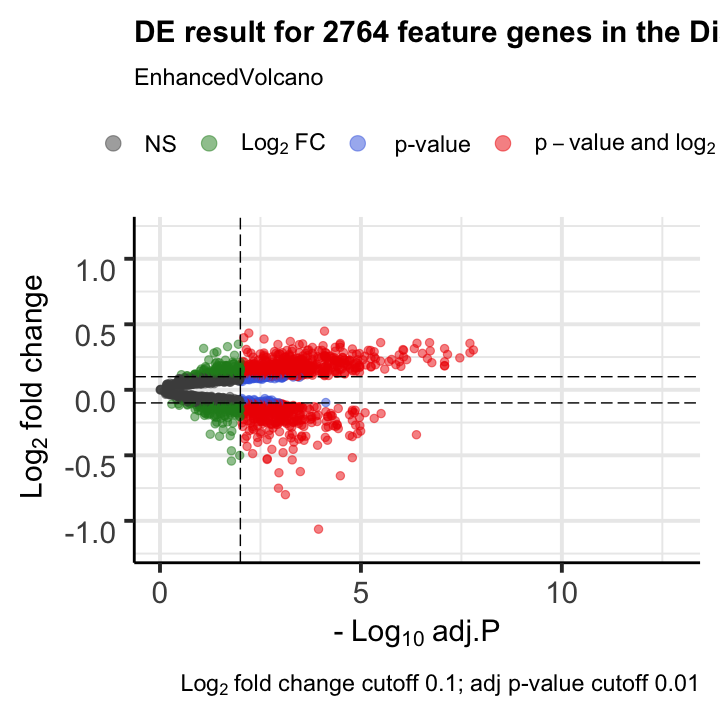

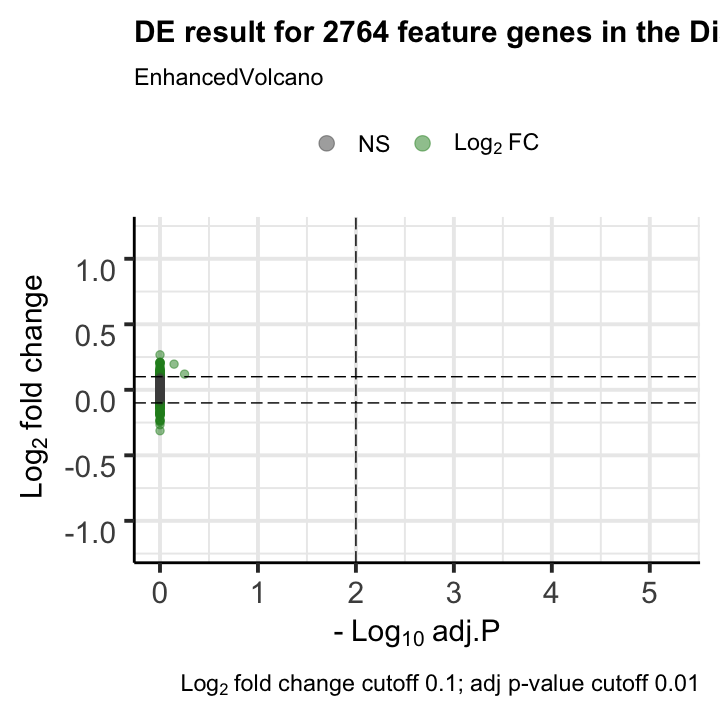

In [114]:
p=EnhancedVolcano(de_main_good_selected,
    lab = de_main_good_selected$geneSymbol,
    x = 'logFC',
    y = "adj.P.Val",
    pCutoff = 0.01,
    FCcutoff = 0.1,
    pointSize = 2.0,
    title = "DE result for 2764 feature genes in the Discovery Dataset",
    caption = bquote(~Log[2]~ "fold change cutoff 0.1; adj p-value cutoff 0.01"),
#     legendPosition = "right",
    legendLabSize = 14,
    xlim=c(-1.2, +1.2),
    ylab="-"~Log[10]~"adj.P",
    labSize = 0,
    width=15) + coord_flip()
                  
# p=p+ggplot2::coord_cartesian(xlim=c(-1.2, +1.2))

p
ggsave(plot = p, width = 8, height = 8, filename = paste0(inputPath,"main_above_volcano.pdf"))

p=EnhancedVolcano(de_main_poor_selected,
    lab = de_main_poor_selected$geneSymbol,
    x = 'logFC',
    y = "adj.P.Val",
    pCutoff = 0.01,
    FCcutoff = 0.1,
    pointSize = 2.0,
    title = "DE result for 2764 feature genes in the Discovery Dataset",
    caption = bquote(~Log[2]~ "fold change cutoff 0.1; adj p-value cutoff 0.01"),
#     legendPosition = "right",
    legendLabSize = 14,
    xlim=c(-1.2, +1.2),
    ylab="-"~Log[10]~"adj.P",
    labSize = 0,
    width=15) + coord_flip()
                  
# p=p+ggplot2::coord_cartesian(xlim=c(-1.2, +1.2))

p
ggsave(plot = p, width = 8, height = 8, filename = paste0(inputPath,"main_below_volcano.pdf"))
# EnhancedVolcano(de_main_good,
#     lab = rownames(de_main_good),
#     x = 'logFC',
#     y = "adj.P.Val",
#     pCutoff = 0.01,
#     FCcutoff = 0.1,
#     pointSize = 3.0,
#     title = "DE result for ",
#     subtitle = "Differential expression",
#     caption = bquote(~Log[2]~ "fold change cutoff, 2; p-value cutoff, 10e-4"),
#     legendPosition = "right",
#     legendLabSize = 14,
#     xlab="-"~Log[10]~"adjP"
#                )
# EnhancedVolcano(de_main_poor,
#     lab = rownames(de_main_poor),
#     x = 'logFC',
#     y = "adj.P.Val",
#     pCutoff = 0.01,
#     FCcutoff = 0.1,
#     pointSize = 3.0)

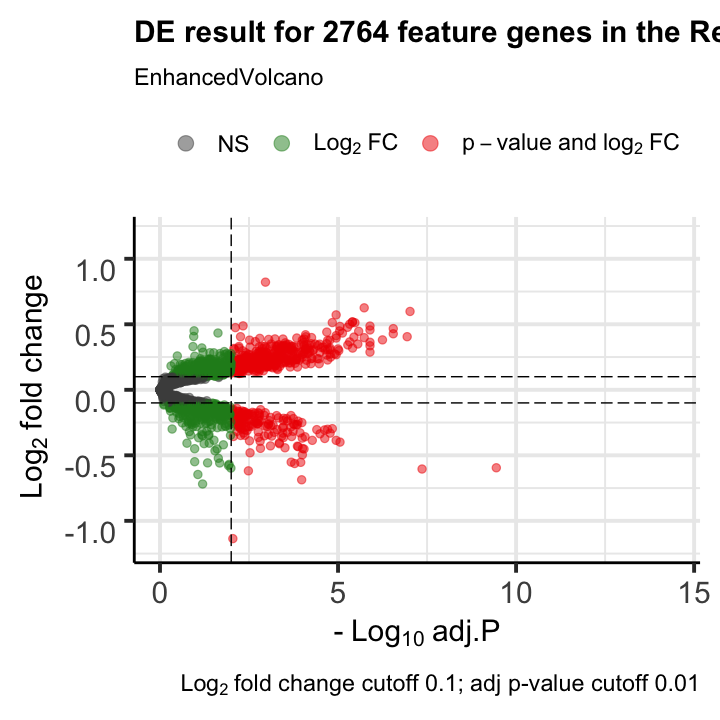

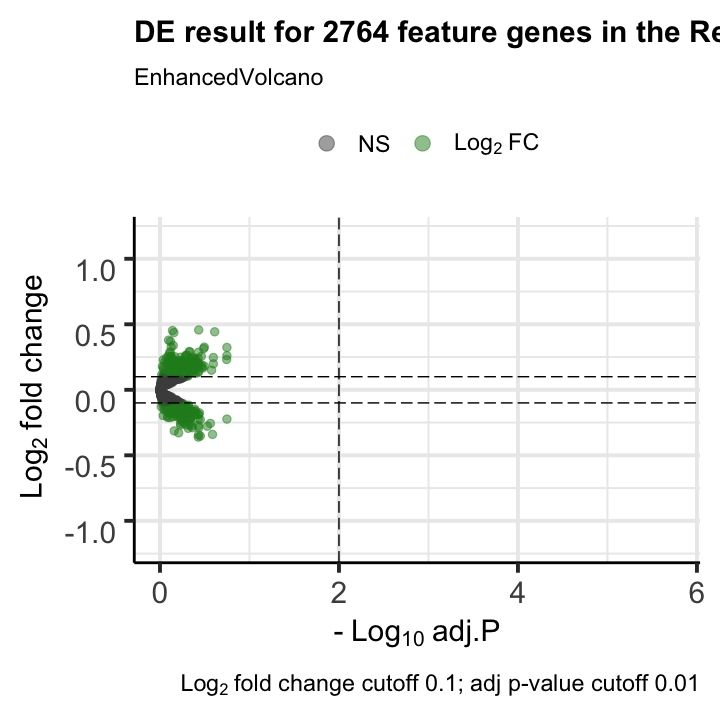

In [116]:
de_test_good = DEtest[['goodClassification']][,c("Entrez_Gene_ID", 'logFC',"adj.P.Val",'P.Value','geneSymbol')]
de_test_poor = DEtest[['poorClassification']][,c("Entrez_Gene_ID", 'logFC',"adj.P.Val",'P.Value','geneSymbol')]

de_test_poor = de_test_poor[which(de_test_poor$Entrez_Gene_ID %in% test_gene_table$geneName),]
de_test_good = de_test_good[which(de_test_good$Entrez_Gene_ID %in% test_gene_table$geneName),]
p=EnhancedVolcano(de_test_good,
    lab = de_test_good$geneSymbol,
    x = 'logFC',
    y = "adj.P.Val",
    pCutoff = 0.01,
    FCcutoff = 0.1,
    pointSize = 2.0,
    title = "DE result for 2764 feature genes in the Replication Dataset",
    caption = bquote(~Log[2]~ "fold change cutoff 0.1; adj p-value cutoff 0.01"),
#     legendPosition = "right",
    legendLabSize = 14,
    xlim=c(-1.2, +1.2),
    ylab="-"~Log[10]~"adj.P",
#     legendIconSize = 4.0,
#     drawConnectors = TRUE,
#     widthConnectors = 1.0,
    labSize = 0,
    width=15) + coord_flip()

p
ggsave(plot = p, width = 8, height = 8, filename = paste0(inputPath,"test_above_volcano.pdf"))
           
# p=p+ggplot2::coord_cartesian(xlim=c(-1.2, +1.2))

p=EnhancedVolcano(de_test_poor,
    lab = de_test_poor$geneSymbol,
    x = 'logFC',
    y = "adj.P.Val",
    pCutoff = 0.01,
    FCcutoff = 0.1,
    pointSize = 2.0,
    title = "DE result for 2764 feature genes in the Replication Dataset",
    caption = bquote(~Log[2]~ "fold change cutoff 0.1; adj p-value cutoff 0.01"),
#     legendPosition = "right",
    legendLabSize = 14,
    xlim=c(-1.2, +1.2),
    ylab="-"~Log[10]~"adj.P",
    labSize = 0,
    width=15) + coord_flip()

p
ggsave(plot = p, width = 8, height = 8, filename = paste0(inputPath,"test_below_volcano.pdf"))
        